# Course Project

## Dataset

The COMPAS score uses answers to 137 questions to assign a risk score to defendants -- essentially a probability of re-arrest. The actual output is two-fold: a risk rating of 1-10 and a "low", "medium", or "high" risk label.

Link to dataset: https://github.com/propublica/compas-analysis

The file we will analyze is: compas-scores-two-years.csv

Link to the ProPublica article:

https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing


## Project goal

The project has three parts: 

- The COMPAS scores have been shown to have biases against certain racial groups. Analyze the dataset to highlight these biases.  

- Based on the features in the COMPAS dataset, train classifiers to predict who will re-offend (hint: no need to use all features, just the ones you find relevant).  Study if your classifiers are more or less fair than the COMPAS classifier. 

- Build a fair classifier (last lecture will cover fair classification techniques). Is excluding the race from the feature set enough?

### Dependency installation

In [1]:
!pip3 install numpy torch pandas matplotlib seaborn scikit-learn lightning

## Download the data

We first need to load the data from the ProPublica repo:
https://github.com/propublica/compas-analysis


In [2]:
import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import scale, LabelBinarizer
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import feature_extraction, preprocessing
from torch.nn import Module, Linear, ReLU, BCELoss, Sigmoid
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam, SGD, AdamW
from torch import no_grad, FloatTensor, LongTensor
from matplotlib.pyplot import subplots, close
from IPython.display import display, update_display
from lightning import LightningModule, Trainer
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from math import sqrt
from pathlib import Path
from urllib.request import urlopen
from random import seed, shuffle
from os import cpu_count


# TODO: remove for real randomness?
SEED = 1234
seed(SEED)
np.random.seed(SEED)

COMPAS_INPUT_FILE = "compas-scores-two-years.csv"
ADDRESS = f"https://raw.githubusercontent.com/propublica/compas-analysis/master/{COMPAS_INPUT_FILE}"

print(f"Looking for file '{COMPAS_INPUT_FILE}' in the current directory...")
path = Path(f"./{COMPAS_INPUT_FILE}")

if not path.exists():
    print("File not found! Downloading from GitHub...")
    with open(path, "wb") as file:
        file.write(urlopen(ADDRESS).read())
    print(f"File '{COMPAS_INPUT_FILE}' download and saved locally.")
else:
    print("File found in current directory.")

Looking for file 'compas-scores-two-years.csv' in the current directory...
File found in current directory.


## Load the Data and clean it up

In the Github Account mentioned above, the ProRepublica People explained to clean the Dataset. They gave the following explanation: 

```
However not all of the rows are useable for the first round of analysis.

There are a number of reasons remove rows because of missing data:

- If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
- We coded the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all.
- In a similar vein, ordinary traffic offenses -- those with a c_charge_degree of 'O' -- will not result in Jail time are removed (only two of them).
- We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.
```

In [3]:
df = pd.read_csv('compas-scores-two-years.csv', delimiter = ',')
print(f'The shape of the COMPAS Dataset is: {df.shape}')
print(f'Number of convicts: {df.shape[0]}')
print(f'Features of the dataset: {", ".join(df.columns.tolist())}')
print('The COMPASS dataset is the following data table:')
df

The shape of the COMPAS Dataset is: (7214, 53)
Number of convicts: 7214
Features of the dataset: id, name, first, last, compas_screening_date, sex, dob, age, age_cat, race, juv_fel_count, decile_score, juv_misd_count, juv_other_count, priors_count, days_b_screening_arrest, c_jail_in, c_jail_out, c_case_number, c_offense_date, c_arrest_date, c_days_from_compas, c_charge_degree, c_charge_desc, is_recid, r_case_number, r_charge_degree, r_days_from_arrest, r_offense_date, r_charge_desc, r_jail_in, r_jail_out, violent_recid, is_violent_recid, vr_case_number, vr_charge_degree, vr_offense_date, vr_charge_desc, type_of_assessment, decile_score.1, score_text, screening_date, v_type_of_assessment, v_decile_score, v_score_text, v_screening_date, in_custody, out_custody, priors_count.1, start, end, event, two_year_recid
The COMPASS dataset is the following data table:


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
7211,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,...,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
7212,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,...,2,Low,2014-03-09,2014-03-08,2014-03-09,3,0,754,0,0


In [4]:
df = df.dropna(subset=["days_b_screening_arrest"]) # dropping missing vals
df = df[(df.days_b_screening_arrest <= 30) & (df.days_b_screening_arrest >= -30) & (df.is_recid != -1) & (df.c_charge_degree != 'O') & (df.score_text != 'N/A')]
df.reset_index(inplace=True, drop=True) # renumber the rows from 0 again
print('The cleaned dataset after the instructions from ProPublica is the following:')
df 


The cleaned dataset after the instructions from ProPublica is the following:


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,...,1,Low,2013-11-30,2013-11-30,2013-12-01,0,1,853,0,0
4,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,...,2,Low,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6167,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
6168,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
6169,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,...,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
6170,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,...,2,Low,2014-03-09,2014-03-08,2014-03-09,3,0,754,0,0


# Analysis of the COMPAS DATATSET
Following the analysis of the ProPublica people, we can see that a higher COMPAS scores are slightly correlated with a longer length of stay.

Also, we'll be adding some complex features here.

In [5]:
df['c_length_of_stay'] = (pd.to_datetime(df['c_jail_out']) - pd.to_datetime(df['c_jail_in'])).dt.days
df['f_length_of_stay'] = (pd.to_datetime(df['c_arrest_date']) - pd.to_datetime(df['c_offense_date'])).dt.days
df['length_of_custody'] = (pd.to_datetime(df['in_custody']) - pd.to_datetime(df['out_custody'])).dt.days
print(f'COMPAS scores correlation towards length of stay: {round(df["c_length_of_stay"].corr(df["decile_score"]), 5)}')

COMPAS scores correlation towards length of stay: 0.20748


Here we can see, that most of the prisoners are 25-45 years old. 

What is the number of people by race? Here you can see the percentage of each group in this dataset.


In [6]:
race_df = df.groupby(['age_cat']).size()
pd.DataFrame([race_df, race_df.transform(lambda x: x/sum(x))], ["Absolute value", "Percentage"])

age_cat,25 - 45,Greater than 45,Less than 25
Absolute value,3532.000000,1293.000000,1347.000000
Percentage,0.572262,0.209494,0.218244


Same about sex:

In [7]:
sex_df = df.groupby(['sex']).size()
pd.DataFrame([sex_df.astype(np.uint64), sex_df.transform(lambda x: x/sum(x))], ["Absolute value", "Percentage"])

sex,Female,Male
Absolute value,1175.000000,4997.000000
Percentage,0.190376,0.809624


Decile score distribution by sex:

In [8]:
pd.crosstab(df['score_text'], df['sex'], dropna=False).transform(lambda x: x/sum(x))

sex,Female,Male
score_text,,
High,0.128511,0.198719
Low,0.594894,0.544727
Medium,0.276596,0.256554


Decile score distribution by race:

In [9]:
pd.crosstab(df['score_text'], df['race'], dropna=False).transform(lambda x: x/sum(x))

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
score_text,,,,,,
High,0.266142,0.096774,0.106039,0.092338,0.363636,0.064140
Low,0.423937,0.774194,0.669044,0.722986,0.272727,0.795918
Medium,0.309921,0.129032,0.224917,0.184676,0.363636,0.139942


What is the number of people by COMPAS risk category (`score_text`)?

In [10]:
score_df = df.groupby(['score_text']).size()
pd.DataFrame([score_df, score_df.transform(lambda x: x/sum(x))], ["Absolute value", "Percentage"])

score_text,High,Low,Medium
Absolute value,1144.000000,3421.000000,1607.000000
Percentage,0.185353,0.554277,0.260369


What is the number of people by COMPAS score (`decile_score`)?


In [11]:
score_num_df = df.groupby(['decile_score']).size()
pd.DataFrame([score_num_df, score_num_df.transform(lambda x: x/sum(x))], ["Absolute value", "Percentage"])

decile_score,1,2,3,4,5,6,7,8,9,10
Absolute value,1286.00000,822.000000,647.000000,666.000000,582.000000,529.00000,496.000000,420.000000,420.000000,304.000000
Percentage,0.20836,0.133182,0.104828,0.107907,0.094297,0.08571,0.080363,0.068049,0.068049,0.049255


# Basic investigations of gender and race bias in COMPAS scores

Basic investigations of gender and race bias in COMPAS scores
`decile_score` -- is the score given by the COMPAS algorithm that estimates the risk to re-offend.

`score_text` -- is the level of risk: Low, Medium, High

`two_years_recid` -- is the ground truth data on whether the offender recidivated or not

What is the mean COMPAS score (`decile_score`) per race and gender?

In [12]:
pd.crosstab(index = df['sex'], columns = df['race'], values = df['decile_score'], aggfunc = 'mean')

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
sex,,,,,,
Female,4.639344,2.000000,3.792531,2.682927,8.5,2.741379
Male,5.410129,2.896552,3.588526,3.517564,6.0,2.919298


What is the distribution (histogram) of `decile_score` per race and gender?

/tmp/ipykernel_1172224/2689900771.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


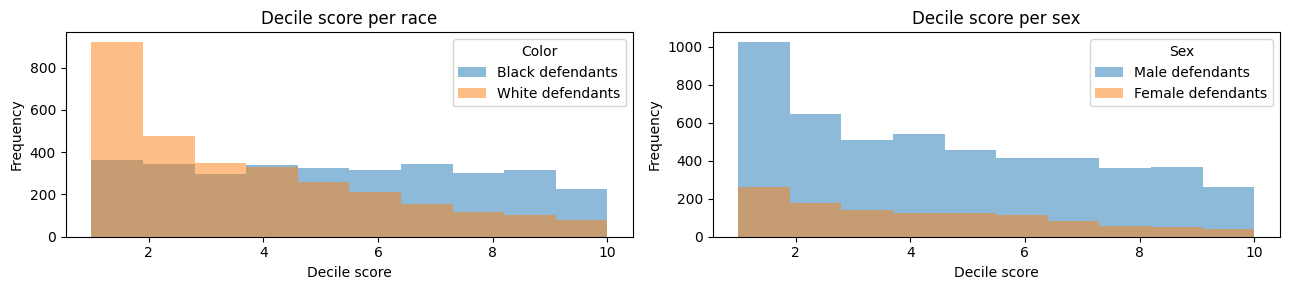

In [13]:
decile_df = pd.DataFrame({'decile_score': df['decile_score'], 'race': df['race'], 'sex': df['sex']})
black = decile_df.loc[decile_df['race'] == 'African-American', 'decile_score']
nonblack = decile_df.loc[(decile_df['race'] != 'African-American') , 'decile_score']
male = decile_df.loc[decile_df['sex'] == 'Male', 'decile_score']
female = decile_df.loc[decile_df['sex'] == 'Female', 'decile_score']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 3))

ax1.hist(black, alpha=0.5, label='Black defendants')
ax1.hist(nonblack, alpha=0.5, label='White defendants')
ax1.set_title('Decile score per race')
ax1.set_xlabel('Decile score')
ax1.set_ylabel('Frequency')
ax1.legend(title='Color')

ax2.hist(male, alpha=0.5, label='Male defendants')
ax2.hist(female, alpha=0.5, label='Female defendants')
ax2.set_title('Decile score per sex')
ax2.set_xlabel('Decile score')
ax2.set_ylabel('Frequency')
ax2.legend(title='Sex')

fig.tight_layout()
fig.show()


The `two_year_recid` field records whether each person was re-arrested for a violent offense within two years, which is what COMPAS is trying to predict.

- How many people were re-arrested? 

In [14]:
recid_df = df.groupby(['two_year_recid']).size()
pd.DataFrame([recid_df, recid_df.transform(lambda x: x/sum(x))], ["Absolute value", "Percentage"]).rename(columns=lambda x: bool(x))

two_year_recid,False,True
Absolute value,3363.00000,2809.00000
Percentage,0.54488,0.45512


Compute the recidivism (i.e., people that got re-arrested) rates by race and gender

In [15]:
pd.crosstab(df['race'], df['two_year_recid']).transform(lambda x: x/sum(x), axis = 1).rename(columns=lambda x: bool(x))

two_year_recid,False,True
race,,
African-American,0.476850,0.523150
Asian,0.741935,0.258065
Caucasian,0.609130,0.390870
Hispanic,0.628684,0.371316
Native American,0.545455,0.454545
Other,0.638484,0.361516


In [16]:
pd.crosstab(df['sex'], df['two_year_recid']).transform(lambda x: x/sum(x), axis = 1).rename(columns=lambda x: bool(x))

two_year_recid,False,True
sex,,
Female,0.648511,0.351489
Male,0.520512,0.479488


What is the accuracy of the COMPAS scores to predict recidivism ? 

In [17]:
predicted_recid = df['decile_score'].transform(lambda x: 1 if (x >= 5) else 0)
two_year_df = pd.DataFrame({'two_year_recid': df['two_year_recid'], 'recid_predict': predicted_recid})
print(f'COMPAS score to predict recidivism: {round(accuracy_score(two_year_df["two_year_recid"], two_year_df["recid_predict"], normalize = True), 5)}')

COMPAS score to predict recidivism: 0.66073


- Is the accuracy higher/lower if we look at particular races/genders?


In [18]:
decile_race_sex_recid = pd.DataFrame({'decile_score': df['decile_score'], 'race': df['race'], 'sex': df['sex'], 'two_year_recid': df['two_year_recid']})

decile_black = decile_race_sex_recid.loc[decile_race_sex_recid['race'] == 'African-American']
predicted_recid_black = decile_black['decile_score'].transform(lambda x: 1 if (x >= 5) else 0)
black_recid = pd.DataFrame({'two_year_recid': decile_black['two_year_recid'], 'recid_predict': predicted_recid_black})
black_acc = accuracy_score(black_recid['two_year_recid'], black_recid['recid_predict'], normalize = True)

decile_nonblack = decile_race_sex_recid.loc[decile_race_sex_recid['race'] != 'African-American']
predicted_recid_nonblack = decile_nonblack['decile_score'].transform(lambda x: 1 if (x >= 5) else 0)
nonblack_recid = pd.DataFrame({'two_year_recid': decile_nonblack['two_year_recid'], 'recid_predict': predicted_recid_nonblack})
nonblack_acc = accuracy_score(nonblack_recid['two_year_recid'], nonblack_recid['recid_predict'], normalize = True)

decile_male = decile_race_sex_recid.loc[decile_race_sex_recid['sex'] == 'Male']
predicted_recid_male = decile_male['decile_score'].transform(lambda x: 1 if (x >= 5) else 0)
male_recid = pd.DataFrame({'two_year_recid': decile_male['two_year_recid'], 'recid_predict': predicted_recid_male})
male_acc = accuracy_score(male_recid['two_year_recid'], male_recid['recid_predict'], normalize = True)

decile_female = decile_race_sex_recid.loc[decile_race_sex_recid['race'] != 'Male']
predicted_recid_female = decile_female['decile_score'].transform(lambda x: 1 if (x >= 5) else 0)
female_recid = pd.DataFrame({'two_year_recid': decile_female['two_year_recid'], 'recid_predict': predicted_recid_female})
female_acc = accuracy_score(female_recid['two_year_recid'], female_recid['recid_predict'], normalize = True)

print(f'Accurace score black: {round(black_acc, 5)}')
print(f'Accurace score nonblack: {round(nonblack_acc, 5)}')
print(f'Accurace score male: {round(male_acc, 5)}')
print(f'Accurace score female: {round(female_acc, 5)}')

Accurace score black: 0.64913
Accurace score nonblack: 0.67301
Accurace score male: 0.6604
Accurace score female: 0.66073


We can see here that the score for the non black is higher then for the black people. This is a bias with a significant difference of 2.3%


- What about false positives and false negatives?

/tmp/ipykernel_1172224/1229540109.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


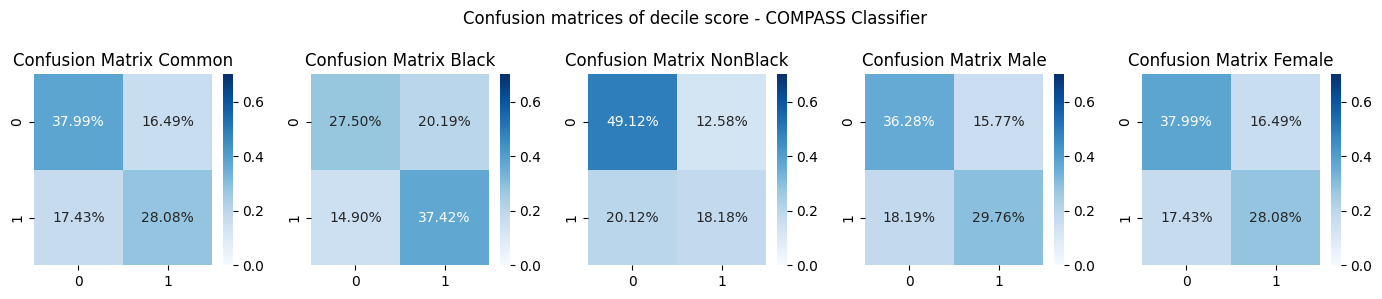

In [19]:
cm = confusion_matrix(two_year_df['two_year_recid'], two_year_df['recid_predict'])
cm_black = confusion_matrix(black_recid['two_year_recid'], predicted_recid_black)
cm_nonblack = confusion_matrix(nonblack_recid['two_year_recid'], predicted_recid_nonblack)
cm_male = confusion_matrix(male_recid['two_year_recid'], predicted_recid_male)
cm_female = confusion_matrix(female_recid['two_year_recid'], predicted_recid_female)

fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(14, 3))
fig.suptitle('Confusion matrices of decile score - COMPASS Classifier')

sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues', ax=ax1, vmin=0.0, vmax=0.7)
ax1.set_title("Confusion Matrix Common")
sns.heatmap(cm_black / np.sum(cm_black), annot=True, fmt='.2%', cmap='Blues', ax=ax2, vmin=0.0, vmax=0.7)
ax2.set_title("Confusion Matrix Black")
sns.heatmap(cm_nonblack / np.sum(cm_nonblack), annot=True, fmt='.2%', cmap='Blues', ax=ax3, vmin=0.0, vmax=0.7)
ax3.set_title("Confusion Matrix NonBlack")
sns.heatmap(cm_male / np.sum(cm_male), annot=True, fmt='.2%', cmap='Blues', ax=ax4, vmin=0.0, vmax=0.7)
ax4.set_title("Confusion Matrix Male")
sns.heatmap(cm_female / np.sum(cm_female), annot=True, fmt='.2%', cmap='Blues', ax=ax5, vmin=0.0, vmax=0.7)
ax5.set_title("Confusion Matrix Female")

for ax in fig.get_axes():
  ax.label_outer()

fig.tight_layout()
fig.show()

We see that the COMPASS Algorithm is relativly balanced:  Half the predicted defendants would re-offend (and half predicted not) which is in the same order of magnitude as the actual statistics.

 - 35%  got an incorrect decision, but this is balanced between false positives and false negatives.

Next to it we can see two separate confusion matrixes for black and non-black defendants:

Confusion Matrix: ( True Negatives, False Positives, \
                    False Negatives, Ture Positives) \

# FPR and FNR

If we look at the white and black groups separately, we get different results: 

 - More blacks receive a false prediction (worse) that they will reoffend than the white defendants. 
 - Again, more whites receive a false prediction (better) that they will not reoffend than the black defendants. 

Accuracy is not the only measure we can look at to compare the impact of algortihm on different groups. For this, we look at what is meant by false-negative and false-positive in our example: 

 - False negative: person who has a prediction not to reoffend and then does reoffend.

 - False positive: person who has a prediction to reoffend and then does not. 

What can we conclude from this?
 - Among black defendants, half of all non-recidivists are falsely imprisoned.   
 - Among whites, half of all repeat offenders are falsely not incarcerated. Thus, the algorithm rates black defendants worse than white defendants.


-> FNR is the proportion of those who re-offended, but released.

-> FPR is the proportion of those who not re-offended, but imprisoned.

In [20]:
def calculate_fnr_and_fpr(confusion):
  TP = confusion[1,1]
  TN = confusion[0,0]
  FP = confusion[0,1]
  FN = confusion[1,0]
  return FN / (TP + FN), FP / (FP + TN)

fnr, fpr = calculate_fnr_and_fpr(cm)
fnr_black, fpr_black = calculate_fnr_and_fpr(cm_black)
fnr_nonblack, fpr_nonblack = calculate_fnr_and_fpr(cm_nonblack)
fnr_male, fpr_male = calculate_fnr_and_fpr(cm_male)
fnr_female, fpr_female = calculate_fnr_and_fpr(cm_female)

print(f'False Positive Rate: {round(fnr, 5)}, False Positive Rate: {round(fpr, 5)}')
print(f'False Negative Rate black: {round(fnr_black, 5)}, False Positive Rate black: {round(fpr_black, 5)}')
print(f'False Negative Rate nonblack: {round(fnr_nonblack, 5)}, False Positive Rate nonblack: {round(fpr_nonblack, 5)}')
print(f'False Negative Rate male: {round(fnr_male, 5)}, False Positive Rate male: {round(fpr_male, 5)}')
print(f'False Negative Rate female: {round(fnr_female, 5)}, False Positive Rate female: {round(fpr_female, 5)}')

False Positive Rate: 0.38305, False Positive Rate: 0.30271
False Negative Rate black: 0.28477, False Positive Rate black: 0.42338
False Negative Rate nonblack: 0.52526, False Positive Rate nonblack: 0.20389
False Negative Rate male: 0.37938, False Positive Rate male: 0.30296
False Negative Rate female: 0.38305, False Positive Rate female: 0.30271


# Demographic Parity
Demographic parity is fullfielled if , for all a,b ∈ A

$$ P(C=1|A=a)=P(C=1|A=b) $$

That means, that it is the same probability to get classified true if you are coming from different demographic groups. 


/tmp/ipykernel_1172224/2203188263.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


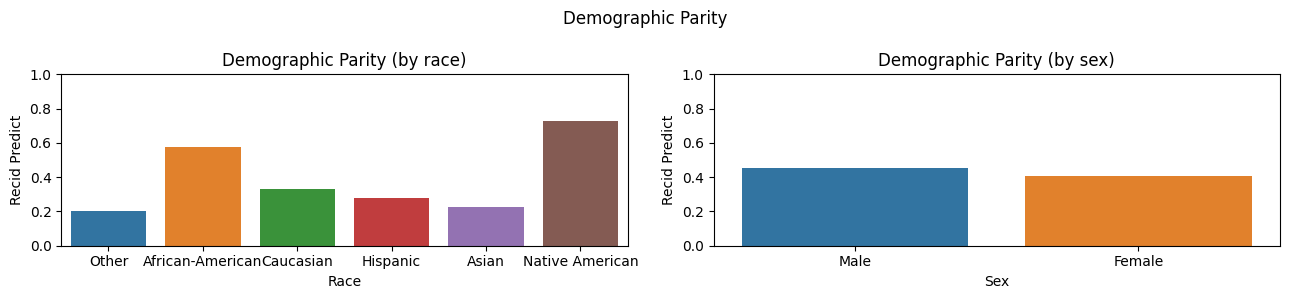

In [21]:
predicted_recid = df['decile_score'].transform(lambda x: 1 if (x >= 5) else 0)
dem_par = pd.DataFrame({'race': df['race'], 'sex': df['sex'], 'recid_predict': predicted_recid})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 3))
plt.suptitle('Demographic Parity')

sns.barplot(data=dem_par, x='race', y='recid_predict', ax=ax1, errorbar=None)
ax1.set_title('Demographic Parity (by race)')
ax1.set_xlabel('Race')
ax1.set_ylabel('Recid Predict')
ax1.set(ylim=(0, 1))

sns.barplot(data=dem_par, x='sex', y='recid_predict', ax=ax2, errorbar=None)
ax2.set_title('Demographic Parity (by sex)')
ax2.set_xlabel('Sex')
ax2.set_ylabel('Recid Predict')
ax2.set(ylim=(0, 1))

fig.tight_layout()
fig.show()

#Accuracy Parity
**Definition:**  accuracy parity is, for all a,b∈A

> P(C=Y|A=a)=P(C=Y|A=b).

Accuracy parity means  equal accuracy in the groups.

/tmp/ipykernel_1172224/2359762487.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


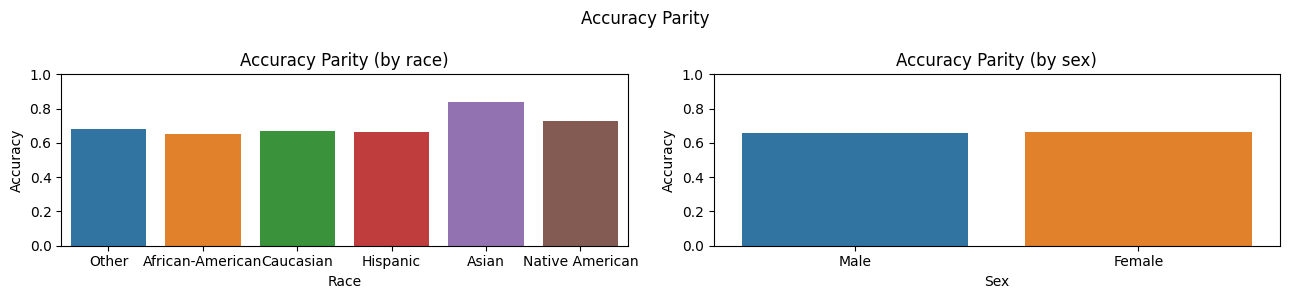

In [22]:
accuracy = ((predicted_recid + df['two_year_recid']) + 1) % 2
acc_par = pd.DataFrame({'race': df['race'], 'sex': df['sex'], 'accuracy': accuracy})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 3))
plt.suptitle('Accuracy Parity')

sns.barplot(data=acc_par, x='race', y='accuracy', ax=ax1, errorbar=None)
ax1.set_title('Accuracy Parity (by race)')
ax1.set_xlabel('Race')
ax1.set_ylabel('Accuracy')
ax1.set(ylim=(0, 1))

sns.barplot(data=acc_par, x='sex', y='accuracy', ax=ax2, errorbar=None)
ax2.set_title('Accuracy Parity (by sex)')
ax2.set_xlabel('Sex')
ax2.set_ylabel('Accuracy')
ax2.set(ylim=(0, 1))

fig.tight_layout()
fig.show()

# Predictive Value Parity (PPV-Parity and NPV-Parity)
Predictive value parity is satisfied <=> PPV-parity and NPV-parity are satisfied.

**Definition:**  PPV-parity is, for all a,b in A


$$ P(Y=1|C=1,A=a)=P(Y=1|C=1,A=b)$$



**Definition:** NPV-parity is, for all a,b in A

$$ P(Y=0|C=0,A=a)=P(Y=0|C=0,A=b) $$



/tmp/ipykernel_1172224/2653498784.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


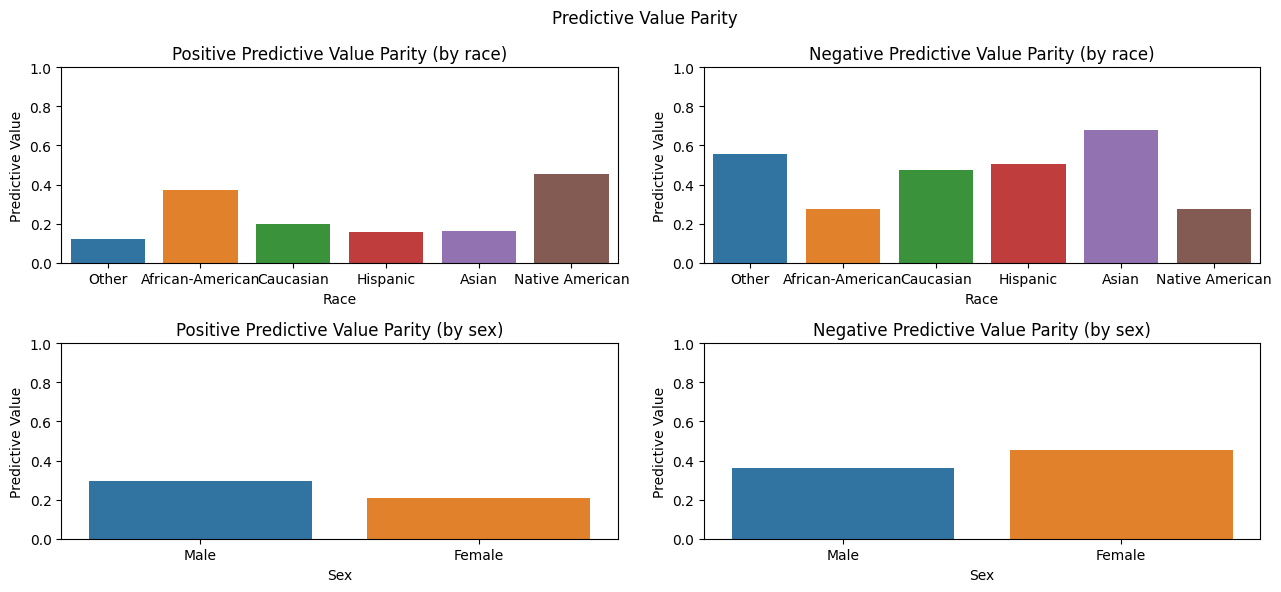

In [23]:
df_pred = predicted_recid + df['two_year_recid']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 6))
plt.suptitle('Predictive Value Parity')

ppvr = df_pred.transform(lambda x : 1 if x == 2 else 0)
ppvr_par = pd.DataFrame({'race': df['race'], 'PPV': ppvr})
sns.barplot(data=ppvr_par, x='race', y='PPV', ax=ax1, errorbar=None)
ax1.set_title('Positive Predictive Value Parity (by race)')
ax1.set_xlabel('Race')
ax1.set_ylabel('Predictive Value')
ax1.set(ylim=(0, 1))

npvr = df_pred.transform(lambda x : 1 if x == 0 else 0)
npvr_par = pd.DataFrame({'race': df['race'], 'NPV': npvr})
sns.barplot(data=npvr_par, x='race', y='NPV', ax=ax2, errorbar=None)
ax2.set_title('Negative Predictive Value Parity (by race)')
ax2.set_xlabel('Race')
ax2.set_ylabel('Predictive Value')
ax2.set(ylim=(0, 1))

ppvs = df_pred.transform(lambda x : 1 if x == 2 else 0)
ppvs_par = pd.DataFrame({'sex': df['sex'], 'PPV': ppvs})
sns.barplot(data=ppvs_par, x='sex', y='PPV', ax=ax3, errorbar=None)
ax3.set_title('Positive Predictive Value Parity (by sex)')
ax3.set_xlabel('Sex')
ax3.set_ylabel('Predictive Value')
ax3.set(ylim=(0, 1))

npvs = df_pred.transform(lambda x : 1 if x == 0 else 0)
npvs_par = pd.DataFrame({'sex': df['sex'], 'NPV': npvs})
sns.barplot(data=npvs_par, x='sex', y='NPV', ax=ax4, errorbar=None)
ax4.set_title('Negative Predictive Value Parity (by sex)')
ax4.set_xlabel('Sex')
ax4.set_ylabel('Predictive Value')
ax4.set(ylim=(0, 1))

fig.tight_layout()
fig.show()

The ROC curve shows us the ratio of true positive rate and false positive rate. If we have a classifier that decides randomly, the ROC curve has the shape of a straight line. The better or more accurate the true positive rate is and the worse the false positive rate is, the better our classifier is.

<img src="https://upload.wikimedia.org/wikipedia/commons/1/13/Roc_curve.svg" width="50%" height="50%">

/tmp/ipykernel_1172224/1937370102.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


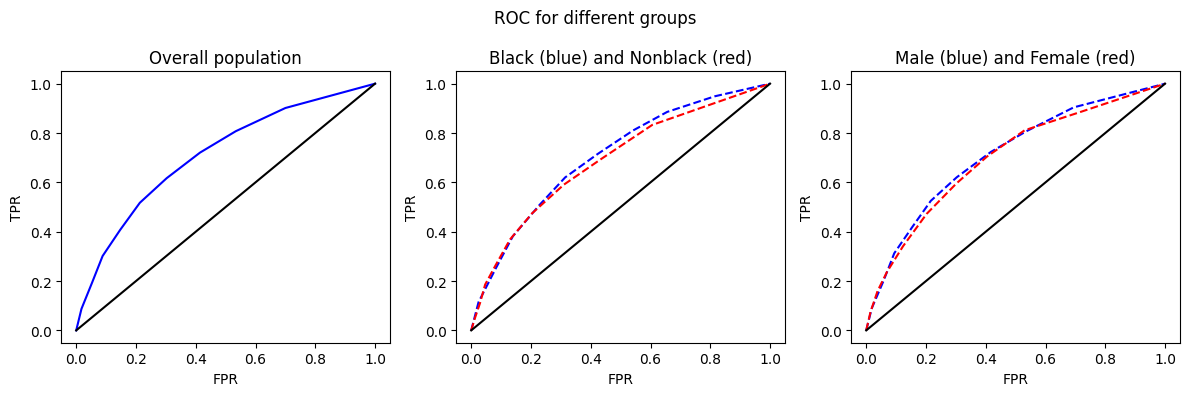

In [24]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle('ROC for different groups')

df_decile = pd.DataFrame({'race': df['race'], 'sex': df['sex'], 'decile_score': df['decile_score'], 'two_year_recid': df['two_year_recid']})
fpr, tpr, thresholds = roc_curve(df_decile['two_year_recid'], df_decile['decile_score'])
ax1.plot(fpr, tpr, 'b')
ax1.set_title('Overall population')
ax1.set_xlabel("FPR")
ax1.set_ylabel("TPR")

df_decile_black = df_decile.loc[df_decile['race'] == 'African-American']
fpr_black, tpr_black, thresholds_black = roc_curve(df_decile_black['two_year_recid'], df_decile_black['decile_score'])
df_decile_nonblack = df_decile.loc[df_decile['race'] != 'African-American']
fpr_nonblack, tpr_nonblack, thresholds_nonblack = roc_curve(df_decile_nonblack['two_year_recid'], df_decile_nonblack['decile_score'])
ax2.plot(fpr_black, tpr_black, 'b--', fpr_nonblack, tpr_nonblack, 'r--')
ax2.set_title('Black (blue) and Nonblack (red)')
ax2.set_xlabel("FPR")
ax2.set_ylabel("TPR")

df_decile_male = df_decile.loc[df_decile['sex'] == 'Male']
fpr_male, tpr_male, thresholds_male = roc_curve(df_decile_male['two_year_recid'], df_decile_male['decile_score'])
df_decile_female = df_decile.loc[df_decile['sex'] != 'Male']
fpr_female, tpr_female, thresholds_female = roc_curve(df_decile_female['two_year_recid'], df_decile_female['decile_score'])
ax3.plot(fpr_male, tpr_male, 'b--', fpr_female, tpr_female, 'r--')
ax3.set_title('Male (blue) and Female (red)')
ax3.set_xlabel("FPR")
ax3.set_ylabel("TPR")

for ax in fig.get_axes():
  ax.add_line(Line2D([0, 1], [0, 1], color='black'))

fig.tight_layout()
fig.show()

/tmp/ipykernel_1172224/1631266066.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


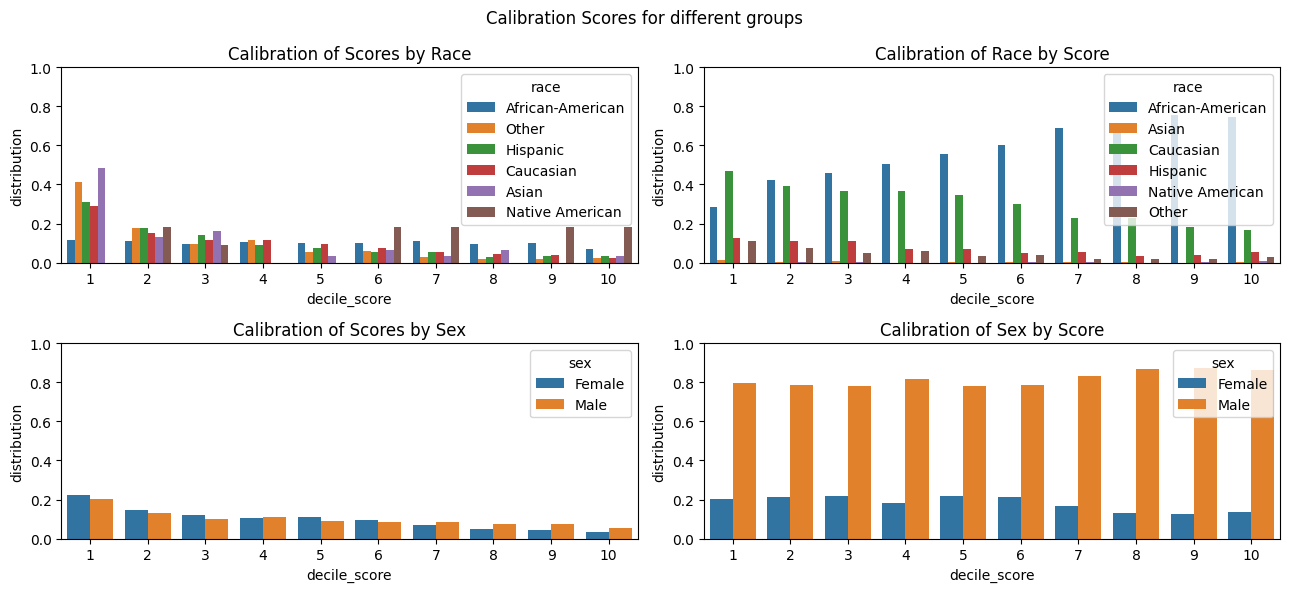

In [25]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 6))
fig.suptitle('Calibration Scores for different groups')

sbrc = (df.groupby(['race'])['decile_score'].value_counts(normalize=True).rename('distribution').reset_index().sort_values(by='decile_score'))
sns.barplot(data=sbrc, x='decile_score', y='distribution', hue='race', ax=ax1)
ax1.set_title('Calibration of Scores by Race')
ax1.set(ylim=(0, 1))

rbsc = (df.groupby(['decile_score'])['race'].value_counts(normalize=True).rename('distribution').reset_index().sort_values(by='race'))
sns.barplot(data=rbsc, x='decile_score', y='distribution', hue='race', ax=ax2);
ax2.set_title('Calibration of Race by Score')
ax2.set(ylim=(0, 1))

sbsec = (df.groupby(['sex'])['decile_score'].value_counts(normalize=True).rename('distribution').reset_index().sort_values(by='decile_score'))
sns.barplot(data=sbsec, x='decile_score', y='distribution', hue='sex', ax=ax3)
ax3.set_title('Calibration of Scores by Sex')
ax3.set(ylim=(0, 1))

sebsc = (df.groupby(['decile_score'])['sex'].value_counts(normalize=True).rename('distribution').reset_index().sort_values(by='sex'))
sns.barplot(data=sebsc, x='decile_score', y='distribution', hue='sex', ax=ax4);
ax4.set_title('Calibration of Sex by Score')
ax4.set(ylim=(0, 1))

fig.tight_layout()
fig.show()

/tmp/ipykernel_1172224/866546551.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


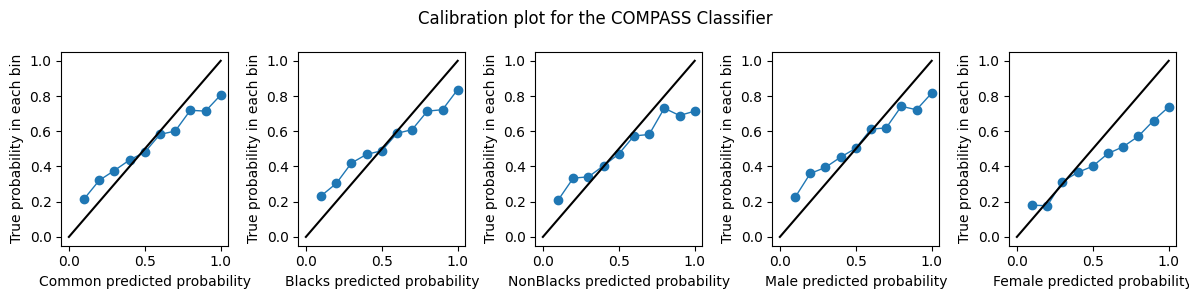

In [26]:
df_score = pd.DataFrame({'race': df['race'], 'sex': df['sex'], 'decile_score': df['decile_score'].transform(lambda x: x/10), 'two_year_recid': df['two_year_recid']})
df_score_black = df_score.loc[df_score['race'] == 'African-American']
df_score_nonblack = df_score.loc[df_score['race'] != 'African-American']
df_score_male = df_score.loc[df_score['sex'] == 'Male']
df_score_female = df_score.loc[df_score['sex'] != 'Male']

prob_true, prob_pred = calibration_curve(df_score['two_year_recid'], df_score['decile_score'], n_bins=10)
prob_true_black, prob_pred_black = calibration_curve(df_score_black['two_year_recid'], df_score_black['decile_score'], n_bins=10)
prob_true_nonblack, prob_pred_nonblack = calibration_curve(df_score_nonblack['two_year_recid'], df_score_nonblack['decile_score'], n_bins=10)
prob_true_male, prob_pred_male = calibration_curve(df_score_male['two_year_recid'], df_score_male['decile_score'], n_bins=10)
prob_true_female, prob_pred_female = calibration_curve(df_score_female['two_year_recid'], df_score_female['decile_score'], n_bins=10)

fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(12, 3))
fig.suptitle('Calibration plot for the COMPASS Classifier')

ax1.plot(prob_pred, prob_true, marker='o', linewidth=1)
ax1.set_xlabel('Common predicted probability')
ax2.plot(prob_pred_black, prob_true_black, marker='o', linewidth=1)
ax2.set_xlabel('Blacks predicted probability')
ax3.plot(prob_pred_nonblack, prob_true_nonblack, marker='o', linewidth=1)
ax3.set_xlabel('NonBlacks predicted probability')
ax4.plot(prob_pred_male, prob_true_male, marker='o', linewidth=1)
ax4.set_xlabel('Male predicted probability')
ax5.plot(prob_pred_female, prob_true_female, marker='o', linewidth=1)
ax5.set_xlabel('Female predicted probability')

for ax in fig.get_axes():
  ax.set_ylabel('True probability in each bin')
  ax.add_line(Line2D([0, 1], [0, 1], color='black'))

fig.tight_layout()
fig.show()

We assume it's not relevant

# Classifier training
> Preparation:
  1. Convert all non-numerical values into numerical ones.
  1. Extract `two_year_recid` column from the dataset.
  2. Create `train` and `test` datasets.


In [27]:
FEATURE_LIST_CONTINUOUS = ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_length_of_stay', 'f_length_of_stay']
FEATURE_LIST_CATEGORICAL = ['sex', 'race', 'c_charge_degree']
binarizers = dict()

df[['f_length_of_stay']] = df[['f_length_of_stay']].fillna(0)

labels_dataset = df['two_year_recid']
features_dataset = np.array([]).reshape(len(labels_dataset), 0)
for _, data in {attr: df[attr] for attr in FEATURE_LIST_CONTINUOUS}.items():
  data = scale([float(v) for v in data])
  data = np.reshape(data, (len(labels_dataset), -1))
  features_dataset = np.hstack((features_dataset, data))
for attribute, data in {attr: df[attr] for attr in FEATURE_LIST_CATEGORICAL}.items():
  enc = LabelBinarizer()
  enc.fit(data)
  binarizers[attribute] = enc
  features_dataset = np.hstack((features_dataset, enc.transform(data)))

features_train, features_test, labels_train, labels_test = train_test_split(features_dataset, labels_dataset)

# We have to extract data for black and non black and for women and non women

# BLACK
black = df.loc[df['race'] == 'African-American']
labels_dataset_black = black['two_year_recid']
features_dataset_black = np.array([]).reshape(len(labels_dataset_black), 0)

for _, data in {attr: black[attr] for attr in FEATURE_LIST_CONTINUOUS}.items():
  data = scale([float(v) for v in data])
  data = np.reshape(data, (len(labels_dataset_black), -1))
  features_dataset_black = np.hstack((features_dataset_black, data))
for attribute, data in {attr: black[attr] for attr in FEATURE_LIST_CATEGORICAL}.items():
  enc = binarizers[attribute]
  features_dataset_black = np.hstack((features_dataset_black, enc.transform(data)))

features_train_black, features_test_black, labels_train_black, labels_test_black = train_test_split(features_dataset_black, labels_dataset_black)

# NONBLACK
nonblack = df.loc[df['race'] != 'African-American']
labels_dataset_nonblack = nonblack['two_year_recid']
features_dataset_nonblack = np.array([]).reshape(len(labels_dataset_nonblack), 0)

for _, data in {attr: nonblack[attr] for attr in FEATURE_LIST_CONTINUOUS}.items():
  data = scale([float(v) for v in data])
  data = np.reshape(data, (len(labels_dataset_nonblack), -1))
  features_dataset_nonblack = np.hstack((features_dataset_nonblack, data))
for attribute, data in {attr: nonblack[attr] for attr in FEATURE_LIST_CATEGORICAL}.items():
  enc = binarizers[attribute]
  features_dataset_nonblack = np.hstack((features_dataset_nonblack, enc.transform(data)))

features_train_nonblack, features_test_nonblack, labels_train_nonblack, labels_test_nonblack = train_test_split(features_dataset_nonblack, labels_dataset_nonblack)

# MALE
male = df.loc[df['sex'] == 'Male']
labels_dataset_male = male['two_year_recid']
features_dataset_male = np.array([]).reshape(len(labels_dataset_male), 0)

for _, data in {attr: male[attr] for attr in FEATURE_LIST_CONTINUOUS}.items():
  data = scale([float(v) for v in data])
  data = np.reshape(data, (len(labels_dataset_male), -1))
  features_dataset_male = np.hstack((features_dataset_male, data))
for attribute, data in {attr: male[attr] for attr in FEATURE_LIST_CATEGORICAL}.items():
  enc = binarizers[attribute]
  features_dataset_male = np.hstack((features_dataset_male, enc.transform(data)))

features_train_male, features_test_male, labels_train_male, labels_test_male = train_test_split(features_dataset_male, labels_dataset_male)

# FEMALE
female = df.loc[df['sex'] == 'Female']
labels_dataset_female = female['two_year_recid']
features_dataset_female = np.array([]).reshape(len(labels_dataset_female), 0)

for _, data in {attr: female[attr] for attr in FEATURE_LIST_CONTINUOUS}.items():
  data = scale([float(v) for v in data])
  data = np.reshape(data, (len(labels_dataset_female), -1))
  features_dataset_female = np.hstack((features_dataset_female, data))
for attribute, data in {attr: female[attr] for attr in FEATURE_LIST_CATEGORICAL}.items():
  enc = binarizers[attribute]
  features_dataset_female = np.hstack((features_dataset_female, enc.transform(data)))

features_train_female, features_test_female, labels_train_female, labels_test_female = train_test_split(features_dataset_female, labels_dataset_female)

## Regression algorithms
### Linear regression

We will skip examination of this because of extremely low accuracy.

In [28]:
linreg = LinearRegression().fit(features_train, labels_train)
print(f"Linear Regression Classifier accuracy: {round(linreg.score(features_test, labels_test), 5)}")

Linear Regression Classifier accuracy: 0.12219


## Logistic  Regression

Logistic Regression Classifier accuracy: 0.67596


/tmp/ipykernel_1172224/535386439.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


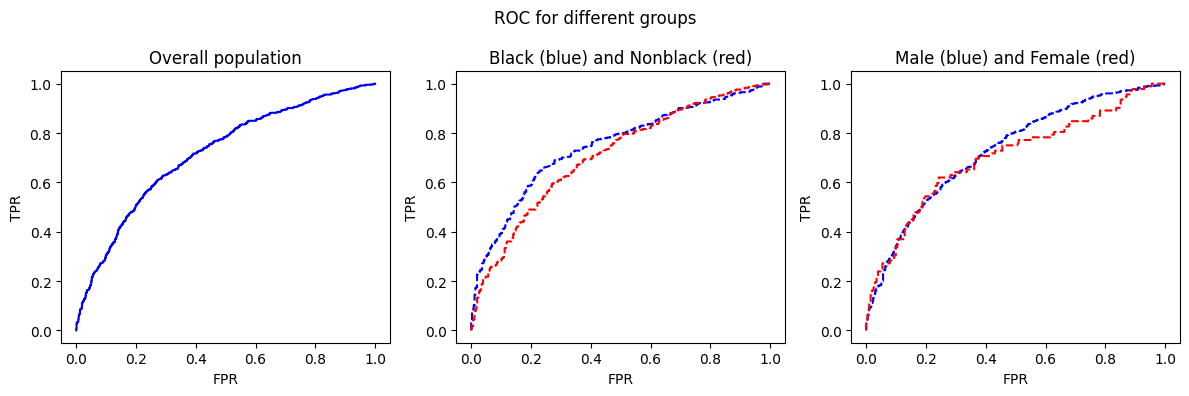

In [29]:
grid = [
    {'C':[1, 10, 100, 1000], 'solver':['lbfgs'], "penalty":["l2"]},
    {'C':[1, 10, 100, 1000],'solver':["newton-cg"], "penalty":["l2"]},
    {'C':[1, 10, 100, 1000],'solver':["liblinear"], "penalty":["l2", "l1"]},
    {'C':[1, 10, 100, 1000],'solver':["newton-cholesky"], "penalty":["l2"]},
]  
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, grid, cv=10)
logreg_cv.fit(features_train, labels_train)

logreg = LogisticRegression(**logreg_cv.best_params_).fit(features_train, labels_train)
print(f"Logistic Regression Classifier accuracy: {round(logreg.score(features_test, labels_test), 5)}")

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle('ROC for different groups')

scores = logreg.predict_proba(features_test)
fpr, tpr, thresholds = roc_curve(labels_test, scores[:,1])
ax1.plot(fpr, tpr, 'b')
ax1.set_title('Overall population')
ax1.set_xlabel("FPR")
ax1.set_ylabel("TPR")

scores_black = logreg.predict_proba(features_test_black)
fpr_black, tpr_black, thresholds_black = roc_curve(labels_test_black, scores_black[:,1])
scores_nonblack = logreg.predict_proba(features_test_nonblack)
fpr_nonblack, tpr_nonblack, thresholds_nonblack = roc_curve(labels_test_nonblack, scores_nonblack[:,1])
ax2.plot(fpr_black, tpr_black, 'b--', fpr_nonblack, tpr_nonblack, 'r--')
ax2.set_title('Black (blue) and Nonblack (red)')
ax2.set_xlabel("FPR")
ax2.set_ylabel("TPR")

scores_male = logreg.predict_proba(features_test_male)
fpr_male, tpr_male, thresholds_male = roc_curve(labels_test_male, scores_male[:,1])
scores_female = logreg.predict_proba(features_test_female)
fpr_female, tpr_female, thresholds_female = roc_curve(labels_test_female, scores_female[:,1])
ax3.plot(fpr_male, tpr_male, 'b--', fpr_female, tpr_female, 'r--')
ax3.set_title('Male (blue) and Female (red)')
ax3.set_xlabel("FPR")
ax3.set_ylabel("TPR")

fig.tight_layout()
fig.show()

The Logistic Function is of the form of
$$ p(x)=\frac{1}{(1+exp(−(β_0+β_1x)))}$$ 
and in the Logistic Regression where are using this to contruct a Score Function to predict the Label Y of our Feature value X. 

The Score Function S  can be described with 

$$
  S(x) =\begin{cases}
    0, & \text{if  $p(x) < threshold$ }\\
    1, & \text{if  $p(x) >= threshold$}
  \end{cases}
$$

The question now is whether the score function can also satisfy the parity criteria or how we can construct the other from the one. For example, one might ask whether the same threshold should be taken for all attributes a from A, or whether different thresholds should be taken.

/tmp/ipykernel_1172224/3071771475.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


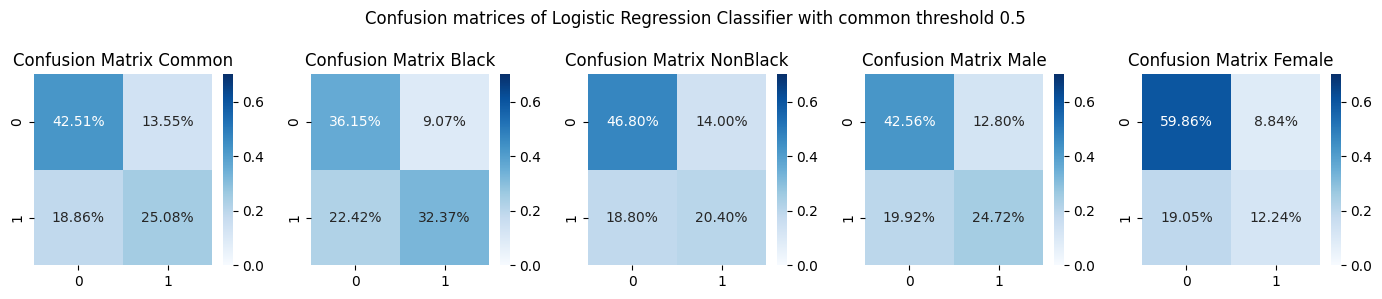

In [30]:
threshold_common = 0.5

def calculate_confusion_matrix(scores, labels_test):
  y_pred_with_threshold = (scores >= threshold_common).astype(int)
  y_pred_with_threshold = np.argmax(y_pred_with_threshold, axis=1)
  return confusion_matrix(labels_test, y_pred_with_threshold)

cm = calculate_confusion_matrix(scores, labels_test)
cm_black = calculate_confusion_matrix(scores_black, labels_test_black)
cm_nonblack = calculate_confusion_matrix(scores_nonblack, labels_test_nonblack)
cm_male = calculate_confusion_matrix(scores_male, labels_test_male)
cm_female = calculate_confusion_matrix(scores_female, labels_test_female)

fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(14, 3))
fig.suptitle('Confusion matrices of Logistic Regression Classifier with common threshold 0.5')

sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues', ax=ax1, vmin=0.0, vmax=0.7)
ax1.set_title("Confusion Matrix Common")
sns.heatmap(cm_black / np.sum(cm_black), annot=True, fmt='.2%', cmap='Blues', ax=ax2, vmin=0.0, vmax=0.7)
ax2.set_title("Confusion Matrix Black")
sns.heatmap(cm_nonblack / np.sum(cm_nonblack), annot=True, fmt='.2%', cmap='Blues', ax=ax3, vmin=0.0, vmax=0.7)
ax3.set_title("Confusion Matrix NonBlack")
sns.heatmap(cm_male / np.sum(cm_male), annot=True, fmt='.2%', cmap='Blues', ax=ax4, vmin=0.0, vmax=0.7)
ax4.set_title("Confusion Matrix Male")
sns.heatmap(cm_female / np.sum(cm_female), annot=True, fmt='.2%', cmap='Blues', ax=ax5, vmin=0.0, vmax=0.7)
ax5.set_title("Confusion Matrix Female")

for ax in fig.get_axes():
  ax.label_outer()

fig.tight_layout()
fig.show()

/tmp/ipykernel_1172224/3854469914.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


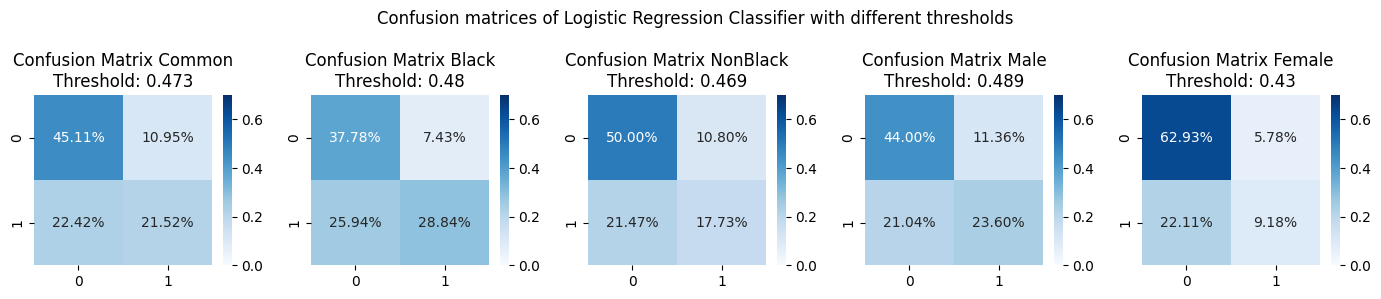

In [31]:
def calculate_confusion_matrix_no_threshhold(scores, features_test, labels_test):
  y_scores = logreg.predict_proba(features_test)[:, 1]
  fpr, tpr, thresholds = roc_curve(labels_test, y_scores)
  optimal_threshold = thresholds[np.argmax(tpr - fpr)]
  y_pred_with_threshold = (scores >= optimal_threshold).astype(int)
  y_pred_with_threshold = np.argmax(y_pred_with_threshold, axis=1)
  return confusion_matrix(labels_test, y_pred_with_threshold), optimal_threshold

cm, th = calculate_confusion_matrix_no_threshhold(scores, features_test, labels_test)
cm_black, th_black = calculate_confusion_matrix_no_threshhold(scores_black, features_test_black, labels_test_black)
cm_nonblack, th_nonblack = calculate_confusion_matrix_no_threshhold(scores_nonblack, features_test_nonblack, labels_test_nonblack)
cm_male, th_male = calculate_confusion_matrix_no_threshhold(scores_male, features_test_male, labels_test_male)
cm_female, th_female = calculate_confusion_matrix_no_threshhold(scores_female, features_test_female, labels_test_female)

fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(14, 3))
fig.suptitle('Confusion matrices of Logistic Regression Classifier with different thresholds')

sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues', ax=ax1, vmin=0.0, vmax=0.7)
ax1.set_title(f"Confusion Matrix Common\nThreshold: {round(th, 3)}")
sns.heatmap(cm_black / np.sum(cm_black), annot=True, fmt='.2%', cmap='Blues', ax=ax2, vmin=0.0, vmax=0.7)
ax2.set_title(f"Confusion Matrix Black\nThreshold: {round(th_black, 3)}")
sns.heatmap(cm_nonblack / np.sum(cm_nonblack), annot=True, fmt='.2%', cmap='Blues', ax=ax3, vmin=0.0, vmax=0.7)
ax3.set_title(f"Confusion Matrix NonBlack\nThreshold: {round(th_nonblack, 3)}")
sns.heatmap(cm_male / np.sum(cm_male), annot=True, fmt='.2%', cmap='Blues', ax=ax4, vmin=0.0, vmax=0.7)
ax4.set_title(f"Confusion Matrix Male\nThreshold: {round(th_male, 3)}")
sns.heatmap(cm_female / np.sum(cm_female), annot=True, fmt='.2%', cmap='Blues', ax=ax5, vmin=0.0, vmax=0.7)
ax5.set_title(f"Confusion Matrix Female\nThreshold: {round(th_female, 3)}")

for ax in fig.get_axes():
  ax.label_outer()

fig.tight_layout()
fig.show()

Calculating calibration scores for the default threshold.

**Definition**  A score function S  is calibrated if f.a. scores s from S
$$ P(Y=1|S=s)=s $$

/tmp/ipykernel_1172224/204239774.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


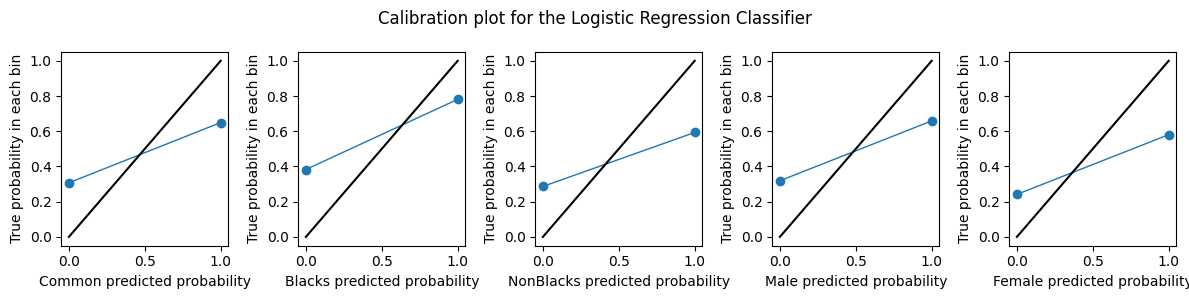

In [32]:
labels_predict = logreg.predict(features_test)
prob_true, prob_pred = calibration_curve(labels_test, labels_predict, n_bins=10)

labels_predict_black = logreg.predict(features_test_black)
prob_true_black, prob_pred_black = calibration_curve(labels_test_black, labels_predict_black, n_bins=10)

labels_predict_nonblack  = logreg.predict(features_test_nonblack)
prob_true_nonblack, prob_pred_nonblack = calibration_curve(labels_test_nonblack, labels_predict_nonblack, n_bins=10)

labels_predict_male = logreg.predict(features_test_male)
prob_true_male, prob_pred_male = calibration_curve(labels_test_male, labels_predict_male, n_bins=10)

labels_predict_female = logreg.predict(features_test_female)
prob_true_female, prob_pred_female = calibration_curve(labels_test_female, labels_predict_female, n_bins=10)

fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(12, 3))
fig.suptitle('Calibration plot for the Logistic Regression Classifier')

ax1.plot(prob_pred, prob_true, marker='o', linewidth=1)
ax1.set_xlabel('Common predicted probability')
ax2.plot(prob_pred_black, prob_true_black, marker='o', linewidth=1)
ax2.set_xlabel('Blacks predicted probability')
ax3.plot(prob_pred_nonblack, prob_true_nonblack, marker='o', linewidth=1)
ax3.set_xlabel('NonBlacks predicted probability')
ax4.plot(prob_pred_male, prob_true_male, marker='o', linewidth=1)
ax4.set_xlabel('Male predicted probability')
ax5.plot(prob_pred_female, prob_true_female, marker='o', linewidth=1)
ax5.set_xlabel('Female predicted probability')

for ax in fig.get_axes():
  ax.set_ylabel('True probability in each bin')
  ax.add_line(Line2D([0, 1], [0, 1], color='black'))

fig.tight_layout()
fig.show()

/tmp/ipykernel_1172224/430975312.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


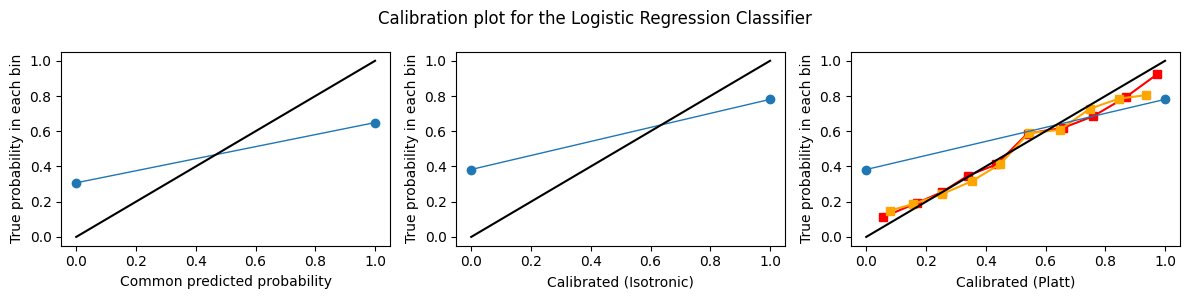

In [33]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(12, 3))
fig.suptitle('Calibration plot for the Logistic Regression Classifier')

# Calibrated
clf_sigmoid = CalibratedClassifierCV(logreg, cv=3, method='isotonic')
clf_sigmoid.fit(features_train, labels_train)
y_test_predict_proba = clf_sigmoid.predict_proba(features_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(labels_test, y_test_predict_proba, n_bins=10)

plt.plot(mean_predicted_value, fraction_of_positives, 's-', color='red', label='Calibrated (Isotonic)')

# Calibrated, Platt
clf_sigmoid = CalibratedClassifierCV(logreg, cv=3, method='sigmoid')
clf_sigmoid.fit(features_train, labels_train)
y_test_predict_proba = clf_sigmoid.predict_proba(features_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(labels_test, y_test_predict_proba, n_bins=10)

plt.plot(mean_predicted_value, fraction_of_positives, 's-', color='orange', label='Calibrated (Platt)')

ax1.plot(prob_pred, prob_true, marker='o', linewidth=1)
ax1.set_xlabel('Common predicted probability')
ax2.plot(prob_pred_black, prob_true_black, marker='o', linewidth=1)
ax2.set_xlabel('Calibrated (Isotronic)')
ax3.plot(prob_pred_black, prob_true_black, marker='o', linewidth=1)
ax3.set_xlabel('Calibrated (Platt)')


for ax in fig.get_axes():
  ax.set_ylabel('True probability in each bin')
  ax.add_line(Line2D([0, 1], [0, 1], color='black'))

fig.tight_layout()
fig.show()

A function is called **calibrated** if the following is satisfied. 

$$ P(Y=1|S=s)=s  $$


Another notion of Fairness **Callibration within groups**
$$ P(Y=1|S=s,A=a)=s,for all s∈R,a∈A $$ 

This will also implies PVP Parity


/tmp/ipykernel_1172224/1469132644.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


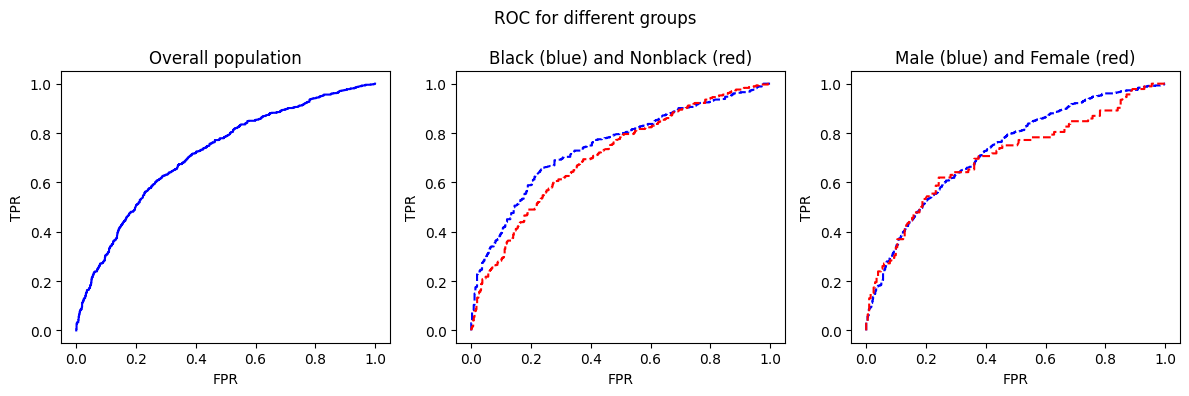

In [34]:
scores = clf_sigmoid.predict_proba(features_test)[:, 1]
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle('ROC for different groups')

scores = clf_sigmoid.predict_proba(features_test)
fpr, tpr, thresholds = roc_curve(labels_test, scores[:,1])
ax1.plot(fpr, tpr, 'b')
ax1.set_title('Overall population')
ax1.set_xlabel("FPR")
ax1.set_ylabel("TPR")

scores_black = clf_sigmoid.predict_proba(features_test_black)
fpr_black, tpr_black, thresholds_black = roc_curve(labels_test_black, scores_black[:,1])
scores_nonblack = clf_sigmoid.predict_proba(features_test_nonblack)
fpr_nonblack, tpr_nonblack, thresholds_nonblack = roc_curve(labels_test_nonblack, scores_nonblack[:,1])
ax2.plot(fpr_black, tpr_black, 'b--', fpr_nonblack, tpr_nonblack, 'r--')
ax2.set_title('Black (blue) and Nonblack (red)')
ax2.set_xlabel("FPR")
ax2.set_ylabel("TPR")

scores_male = clf_sigmoid.predict_proba(features_test_male)
fpr_male, tpr_male, thresholds_male = roc_curve(labels_test_male, scores_male[:,1])
scores_female = clf_sigmoid.predict_proba(features_test_female)
fpr_female, tpr_female, thresholds_female = roc_curve(labels_test_female, scores_female[:,1])
ax3.plot(fpr_male, tpr_male, 'b--', fpr_female, tpr_female, 'r--')
ax3.set_title('Male (blue) and Female (red)')
ax3.set_xlabel("FPR")
ax3.set_ylabel("TPR")

fig.tight_layout()
fig.show()

/tmp/ipykernel_1172224/3007786164.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


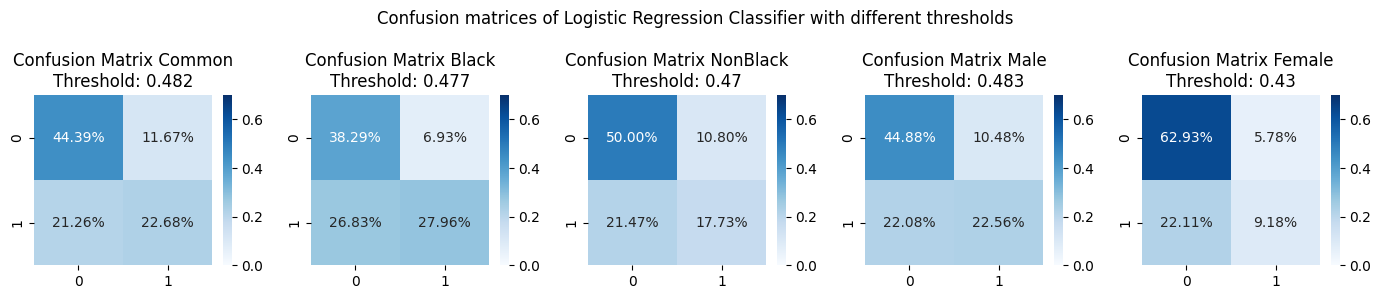

In [35]:
def calculate_confusion_matrix_no_threshhold(scores, features_test, labels_test):
  y_scores = clf_sigmoid.predict_proba(features_test)[:, 1]
  fpr, tpr, thresholds = roc_curve(labels_test, y_scores)
  optimal_threshold = thresholds[np.argmax(tpr - fpr)]
  y_pred_with_threshold = (scores >= optimal_threshold).astype(int)
  y_pred_with_threshold = np.argmax(y_pred_with_threshold, axis=1)
  return confusion_matrix(labels_test, y_pred_with_threshold), optimal_threshold

cm, th = calculate_confusion_matrix_no_threshhold(scores, features_test, labels_test)
cm_black, th_black = calculate_confusion_matrix_no_threshhold(scores_black, features_test_black, labels_test_black)
cm_nonblack, th_nonblack = calculate_confusion_matrix_no_threshhold(scores_nonblack, features_test_nonblack, labels_test_nonblack)
cm_male, th_male = calculate_confusion_matrix_no_threshhold(scores_male, features_test_male, labels_test_male)
cm_female, th_female = calculate_confusion_matrix_no_threshhold(scores_female, features_test_female, labels_test_female)

fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(14, 3))
fig.suptitle('Confusion matrices of Logistic Regression Classifier with different thresholds')

sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues', ax=ax1, vmin=0.0, vmax=0.7)
ax1.set_title(f"Confusion Matrix Common\nThreshold: {round(th, 3)}")
sns.heatmap(cm_black / np.sum(cm_black), annot=True, fmt='.2%', cmap='Blues', ax=ax2, vmin=0.0, vmax=0.7)
ax2.set_title(f"Confusion Matrix Black\nThreshold: {round(th_black, 3)}")
sns.heatmap(cm_nonblack / np.sum(cm_nonblack), annot=True, fmt='.2%', cmap='Blues', ax=ax3, vmin=0.0, vmax=0.7)
ax3.set_title(f"Confusion Matrix NonBlack\nThreshold: {round(th_nonblack, 3)}")
sns.heatmap(cm_male / np.sum(cm_male), annot=True, fmt='.2%', cmap='Blues', ax=ax4, vmin=0.0, vmax=0.7)
ax4.set_title(f"Confusion Matrix Male\nThreshold: {round(th_male, 3)}")
sns.heatmap(cm_female / np.sum(cm_female), annot=True, fmt='.2%', cmap='Blues', ax=ax5, vmin=0.0, vmax=0.7)
ax5.set_title(f"Confusion Matrix Female\nThreshold: {round(th_female, 3)}")

for ax in fig.get_axes():
  ax.label_outer()

fig.tight_layout()
fig.show()

In [36]:
fpr_b, tpr_b, thresholds_b = roc_curve(labels_test_black, labels_predict_black) 
fpr, tpr, thresholds_nb = roc_curve(labels_test_nonblack, labels_predict_nonblack) 
 
df_black = pd.DataFrame({'fpr': fpr_b, 'tpr': tpr_b, 'thresholds_b' : thresholds_b})
df_nonblack = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresholds_nb': thresholds_nb})

intersection_points = pd.merge(df_black.round(3), df_nonblack.round(3), how='inner', on=['fpr', 'tpr'])
intersection_points

,fpr,tpr,thresholds_b,thresholds_nb
0,0.0,0.0,2,2
1,1.0,1.0,0,0


### K nearest neighbor

We can also plot the ROC curve for the model on the global population.

K Nearest Neighbors Classifier accuracy: 0.62605


/tmp/ipykernel_1172224/1425159611.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


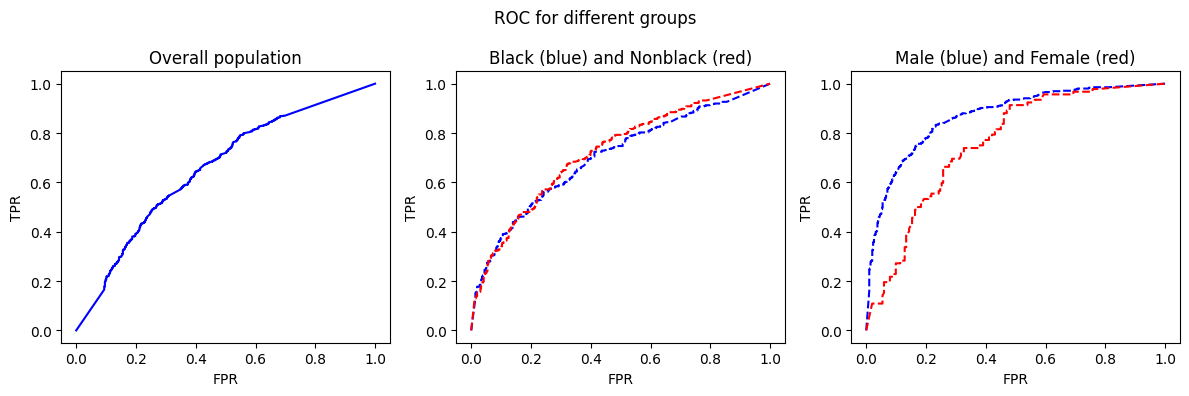

In [37]:
neigh = KNeighborsClassifier(weights='distance').fit(features_train, labels_train)
print(f"K Nearest Neighbors Classifier accuracy: {round(neigh.score(features_test, labels_test), 5)}")

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle('ROC for different groups')

scores = neigh.predict_proba(features_test)
fpr, tpr, thresholds = roc_curve(labels_test, scores[:,1])
ax1.plot(fpr, tpr, 'b')
ax1.set_title('Overall population')
ax1.set_xlabel("FPR")
ax1.set_ylabel("TPR")

scores_black = neigh.predict_proba(features_test_black)
fpr_black, tpr_black, thresholds_black = roc_curve(labels_test_black, scores_black[:,1])
scores_nonblack = neigh.predict_proba(features_test_nonblack)
fpr_nonblack, tpr_nonblack, thresholds_nonblack = roc_curve(labels_test_nonblack, scores_nonblack[:,1])
ax2.plot(fpr_black, tpr_black, 'b--', fpr_nonblack, tpr_nonblack, 'r--')
ax2.set_title('Black (blue) and Nonblack (red)')
ax2.set_xlabel("FPR")
ax2.set_ylabel("TPR")

scores_male = neigh.predict_proba(features_test_male)
fpr_male, tpr_male, thresholds_male = roc_curve(labels_test_male, scores_male[:,1])
scores_female = neigh.predict_proba(features_test_female)
fpr_female, tpr_female, thresholds_female = roc_curve(labels_test_female, scores_female[:,1])
ax3.plot(fpr_male, tpr_male, 'b--', fpr_female, tpr_female, 'r--')
ax3.set_title('Male (blue) and Female (red)')
ax3.set_xlabel("FPR")
ax3.set_ylabel("TPR")

fig.tight_layout()
fig.show()

Plot the ROC curve for Blacks and Whites in two separate curves (in the same plot). What do you observe?

-> We see that there is a difference in the ROC for black and non black. As a recall the definition from wikipedia: 
"The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The true-positive rate is also known as sensitivity, recall or probability of detection.[11] The false-positive rate is also known as probability of false alarm[11] and can be calculated as (1 − specificity). "

So the TPR for the non Black person is higher, so it is biased to the black people an the probably of predict a black person falsy is higher then for non black person. 

Plot the ROC curve for Males and Females in two separate curves (in the same plot). What do you observe?

-> We see that they are almost the same. So here is no Bias

We can finally check the fairness of this k-nearest negihbour classifier, when choosing an arbitrary threshold common to the two groups.

Compute the predictions for a common threshold (threshold_common), then compute the PPV, TPR, FPR (you can use the print_metrics function from above). Comment.

/tmp/ipykernel_1172224/571806654.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


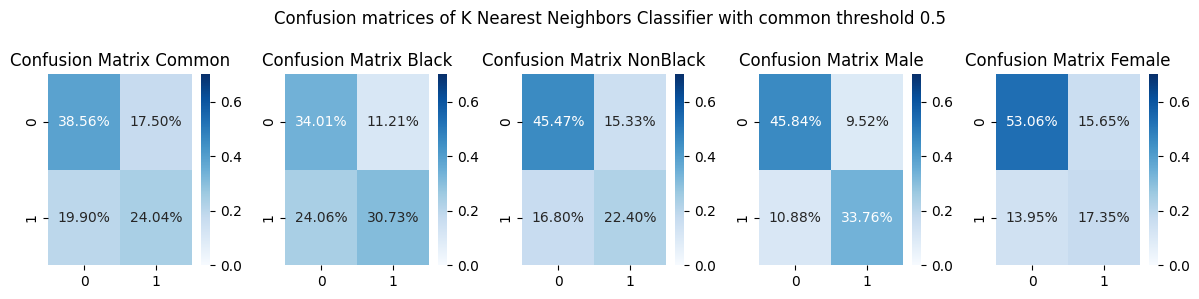

In [38]:
threshold_common = 0.5

def calculate_confusion_matrix(scores, labels_test):
  y_pred_with_threshold = (scores >= threshold_common).astype(int)
  y_pred_with_threshold = np.argmax(y_pred_with_threshold, axis=1)
  return confusion_matrix(labels_test, y_pred_with_threshold)

cm = calculate_confusion_matrix(scores, labels_test)
cm_black = calculate_confusion_matrix(scores_black, labels_test_black)
cm_nonblack = calculate_confusion_matrix(scores_nonblack, labels_test_nonblack)
cm_male = calculate_confusion_matrix(scores_male, labels_test_male)
cm_female = calculate_confusion_matrix(scores_female, labels_test_female)

fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(12, 3))
fig.suptitle('Confusion matrices of K Nearest Neighbors Classifier with common threshold 0.5')

sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues', ax=ax1, vmin=0.0, vmax=0.7)
ax1.set_title("Confusion Matrix Common")
sns.heatmap(cm_black / np.sum(cm_black), annot=True, fmt='.2%', cmap='Blues', ax=ax2, vmin=0.0, vmax=0.7)
ax2.set_title("Confusion Matrix Black")
sns.heatmap(cm_nonblack / np.sum(cm_nonblack), annot=True, fmt='.2%', cmap='Blues', ax=ax3, vmin=0.0, vmax=0.7)
ax3.set_title("Confusion Matrix NonBlack")
sns.heatmap(cm_male / np.sum(cm_male), annot=True, fmt='.2%', cmap='Blues', ax=ax4, vmin=0.0, vmax=0.7)
ax4.set_title("Confusion Matrix Male")
sns.heatmap(cm_female / np.sum(cm_female), annot=True, fmt='.2%', cmap='Blues', ax=ax5, vmin=0.0, vmax=0.7)
ax5.set_title("Confusion Matrix Female")

for ax in fig.get_axes():
  ax.label_outer()

fig.tight_layout()
fig.show()

/tmp/ipykernel_1172224/1468137707.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


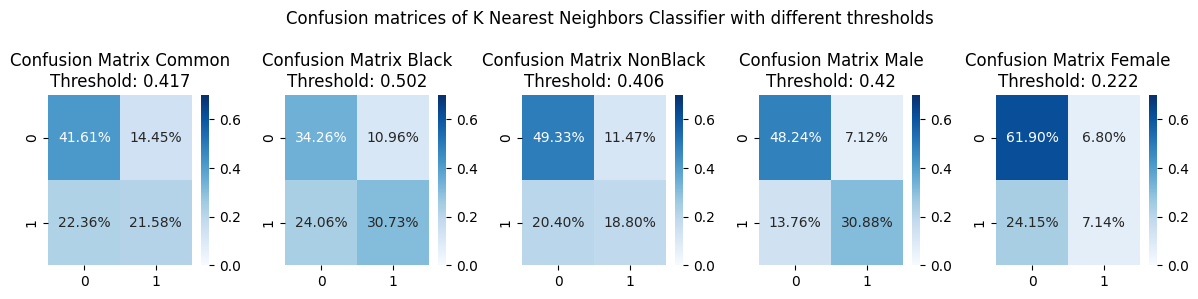

In [39]:
def calculate_confusion_matrix_no_threshhold(scores, features_test, labels_test):
  y_scores = neigh.predict_proba(features_test)[:, 1]
  fpr, tpr, thresholds = roc_curve(labels_test, y_scores)
  optimal_threshold = thresholds[np.argmax(tpr - fpr)]
  y_pred_with_threshold = (scores >= optimal_threshold).astype(int)
  y_pred_with_threshold = np.argmax(y_pred_with_threshold, axis=1)
  return confusion_matrix(labels_test, y_pred_with_threshold), optimal_threshold

cm, th = calculate_confusion_matrix_no_threshhold(scores, features_test, labels_test)
cm_black, th_black = calculate_confusion_matrix_no_threshhold(scores_black, features_test_black, labels_test_black)
cm_nonblack, th_nonblack = calculate_confusion_matrix_no_threshhold(scores_nonblack, features_test_nonblack, labels_test_nonblack)
cm_male, th_male = calculate_confusion_matrix_no_threshhold(scores_male, features_test_male, labels_test_male)
cm_female, th_female = calculate_confusion_matrix_no_threshhold(scores_female, features_test_female, labels_test_female)

fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(12, 3))
fig.suptitle('Confusion matrices of K Nearest Neighbors Classifier with different thresholds')

sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues', ax=ax1, vmin=0.0, vmax=0.7)
ax1.set_title(f"Confusion Matrix Common\nThreshold: {round(th, 3)}")
sns.heatmap(cm_black / np.sum(cm_black), annot=True, fmt='.2%', cmap='Blues', ax=ax2, vmin=0.0, vmax=0.7)
ax2.set_title(f"Confusion Matrix Black\nThreshold: {round(th_black, 3)}")
sns.heatmap(cm_nonblack / np.sum(cm_nonblack), annot=True, fmt='.2%', cmap='Blues', ax=ax3, vmin=0.0, vmax=0.7)
ax3.set_title(f"Confusion Matrix NonBlack\nThreshold: {round(th_nonblack, 3)}")
sns.heatmap(cm_male / np.sum(cm_male), annot=True, fmt='.2%', cmap='Blues', ax=ax4, vmin=0.0, vmax=0.7)
ax4.set_title(f"Confusion Matrix Male\nThreshold: {round(th_male, 3)}")
sns.heatmap(cm_female / np.sum(cm_female), annot=True, fmt='.2%', cmap='Blues', ax=ax5, vmin=0.0, vmax=0.7)
ax5.set_title(f"Confusion Matrix Female\nThreshold: {round(th_female, 3)}")

for ax in fig.get_axes():
  ax.label_outer()

fig.tight_layout()
fig.show()

Finally, we can also investigate the calibration more finely using the calibration module from sklearn.

Complete the code below to plot the calibration curve for the blacks and white separately. Conclude.

/tmp/ipykernel_1172224/46621170.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


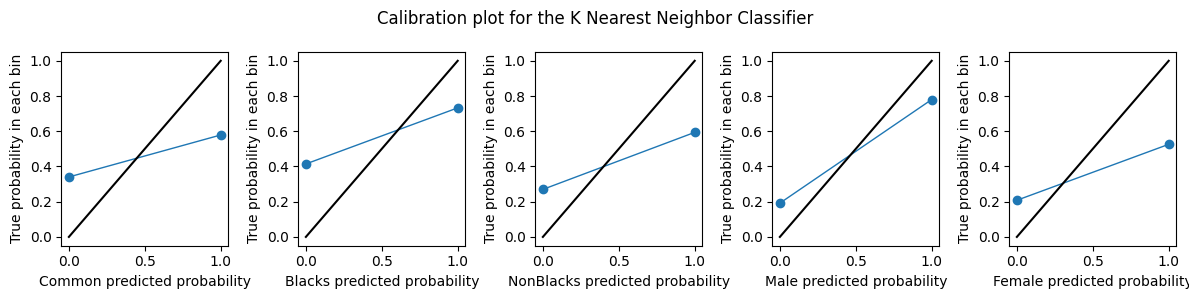

In [40]:
labels_predict = neigh.predict(features_test)
prob_true, prob_pred = calibration_curve(labels_test, labels_predict, n_bins=10)

labels_predict_black = neigh.predict(features_test_black)
prob_true_black, prob_pred_black = calibration_curve(labels_test_black, labels_predict_black, n_bins=10)

labels_predict_nonblack  = neigh.predict(features_test_nonblack)
prob_true_nonblack, prob_pred_nonblack = calibration_curve(labels_test_nonblack, labels_predict_nonblack, n_bins=10)

labels_predict_male = neigh.predict(features_test_male)
prob_true_male, prob_pred_male = calibration_curve(labels_test_male, labels_predict_male, n_bins=10)

labels_predict_female = neigh.predict(features_test_female)
prob_true_female, prob_pred_female = calibration_curve(labels_test_female, labels_predict_female, n_bins=10)

fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(12, 3))
fig.suptitle('Calibration plot for the K Nearest Neighbor Classifier')

ax1.plot(prob_pred, prob_true, marker='o', linewidth=1)
ax1.set_xlabel('Common predicted probability')
ax2.plot(prob_pred_black, prob_true_black, marker='o', linewidth=1)
ax2.set_xlabel('Blacks predicted probability')
ax3.plot(prob_pred_nonblack, prob_true_nonblack, marker='o', linewidth=1)
ax3.set_xlabel('NonBlacks predicted probability')
ax4.plot(prob_pred_male, prob_true_male, marker='o', linewidth=1)
ax4.set_xlabel('Male predicted probability')
ax5.plot(prob_pred_female, prob_true_female, marker='o', linewidth=1)
ax5.set_xlabel('Female predicted probability')

for ax in fig.get_axes():
  ax.set_ylabel('True probability in each bin')
  ax.add_line(Line2D([0, 1], [0, 1], color='black'))

fig.tight_layout()
fig.show()

### Decision Tree

Decision Tree Classifier accuracy: 0.60467


/tmp/ipykernel_1172224/2166386229.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


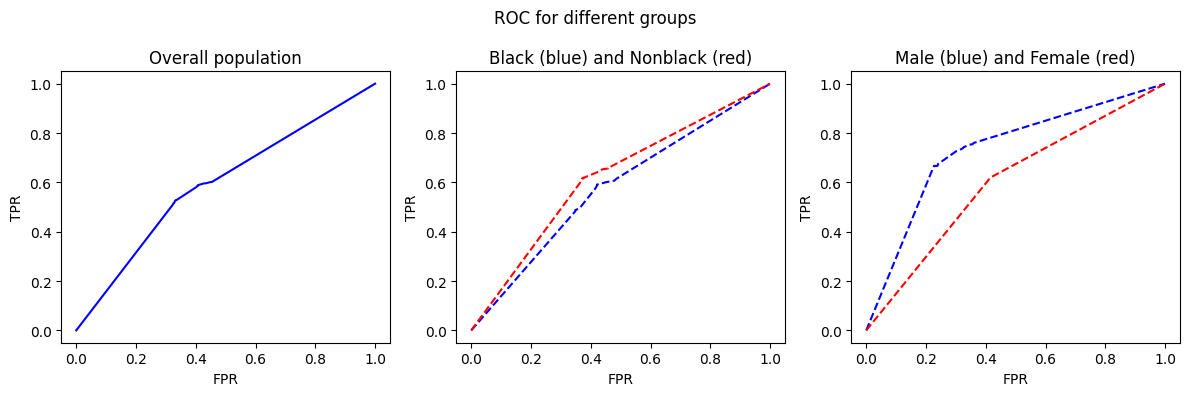

In [41]:
dectr = DecisionTreeClassifier().fit(features_train, labels_train)
print(f"Decision Tree Classifier accuracy: {round(dectr.score(features_test, labels_test), 5)}")

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle('ROC for different groups')

scores = dectr.predict_proba(features_test)
fpr, tpr, thresholds = roc_curve(labels_test, scores[:,1])
ax1.plot(fpr, tpr, 'b')
ax1.set_title('Overall population')
ax1.set_xlabel("FPR")
ax1.set_ylabel("TPR")

scores_black = dectr.predict_proba(features_test_black)
fpr_black, tpr_black, thresholds_black = roc_curve(labels_test_black, scores_black[:,1])
scores_nonblack = dectr.predict_proba(features_test_nonblack)
fpr_nonblack, tpr_nonblack, thresholds_nonblack = roc_curve(labels_test_nonblack, scores_nonblack[:,1])
ax2.plot(fpr_black, tpr_black, 'b--', fpr_nonblack, tpr_nonblack, 'r--')
ax2.set_title('Black (blue) and Nonblack (red)')
ax2.set_xlabel("FPR")
ax2.set_ylabel("TPR")

scores_male = dectr.predict_proba(features_test_male)
fpr_male, tpr_male, thresholds_male = roc_curve(labels_test_male, scores_male[:,1])
scores_female = dectr.predict_proba(features_test_female)
fpr_female, tpr_female, thresholds_female = roc_curve(labels_test_female, scores_female[:,1])
ax3.plot(fpr_male, tpr_male, 'b--', fpr_female, tpr_female, 'r--')
ax3.set_title('Male (blue) and Female (red)')
ax3.set_xlabel("FPR")
ax3.set_ylabel("TPR")

fig.tight_layout()
fig.show()

/tmp/ipykernel_1172224/3706976376.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


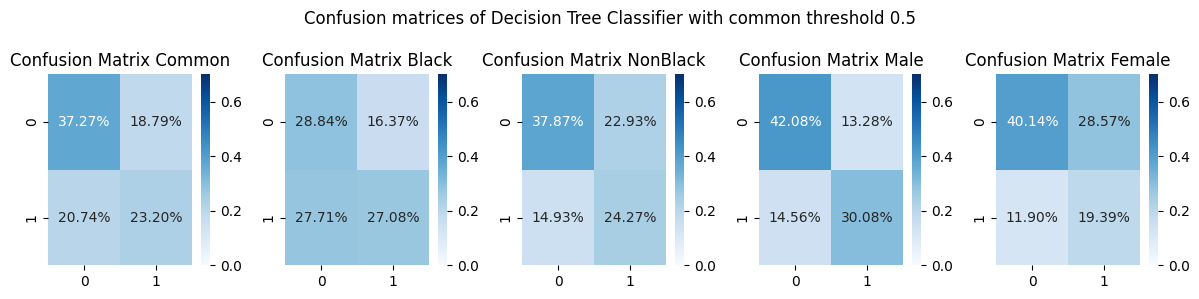

In [42]:
threshold_common = 0.5

def calculate_confusion_matrix(scores, labels_test):
  y_pred_with_threshold = (scores >= threshold_common).astype(int)
  y_pred_with_threshold = np.argmax(y_pred_with_threshold, axis=1)
  return confusion_matrix(labels_test, y_pred_with_threshold)

cm = calculate_confusion_matrix(scores, labels_test)
cm_black = calculate_confusion_matrix(scores_black, labels_test_black)
cm_nonblack = calculate_confusion_matrix(scores_nonblack, labels_test_nonblack)
cm_male = calculate_confusion_matrix(scores_male, labels_test_male)
cm_female = calculate_confusion_matrix(scores_female, labels_test_female)

fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(12, 3))
fig.suptitle('Confusion matrices of Decision Tree Classifier with common threshold 0.5')

sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues', ax=ax1, vmin=0.0, vmax=0.7)
ax1.set_title("Confusion Matrix Common")
sns.heatmap(cm_black / np.sum(cm_black), annot=True, fmt='.2%', cmap='Blues', ax=ax2, vmin=0.0, vmax=0.7)
ax2.set_title("Confusion Matrix Black")
sns.heatmap(cm_nonblack / np.sum(cm_nonblack), annot=True, fmt='.2%', cmap='Blues', ax=ax3, vmin=0.0, vmax=0.7)
ax3.set_title("Confusion Matrix NonBlack")
sns.heatmap(cm_male / np.sum(cm_male), annot=True, fmt='.2%', cmap='Blues', ax=ax4, vmin=0.0, vmax=0.7)
ax4.set_title("Confusion Matrix Male")
sns.heatmap(cm_female / np.sum(cm_female), annot=True, fmt='.2%', cmap='Blues', ax=ax5, vmin=0.0, vmax=0.7)
ax5.set_title("Confusion Matrix Female")

for ax in fig.get_axes():
  ax.label_outer()

fig.tight_layout()
fig.show()

/tmp/ipykernel_1172224/1491972484.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


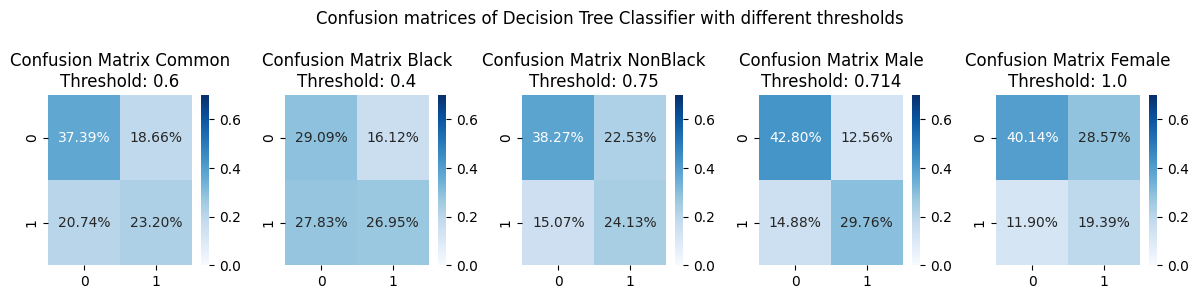

In [43]:
def calculate_confusion_matrix_no_threshhold(scores, features_test, labels_test):
  y_scores = dectr.predict_proba(features_test)[:, 1]
  fpr, tpr, thresholds = roc_curve(labels_test, y_scores)
  optimal_threshold = thresholds[np.argmax(tpr - fpr)]
  y_pred_with_threshold = (scores >= optimal_threshold).astype(int)
  y_pred_with_threshold = np.argmax(y_pred_with_threshold, axis=1)
  return confusion_matrix(labels_test, y_pred_with_threshold), optimal_threshold

cm, th = calculate_confusion_matrix_no_threshhold(scores, features_test, labels_test)
cm_black, th_black = calculate_confusion_matrix_no_threshhold(scores_black, features_test_black, labels_test_black)
cm_nonblack, th_nonblack = calculate_confusion_matrix_no_threshhold(scores_nonblack, features_test_nonblack, labels_test_nonblack)
cm_male, th_male = calculate_confusion_matrix_no_threshhold(scores_male, features_test_male, labels_test_male)
cm_female, th_female = calculate_confusion_matrix_no_threshhold(scores_female, features_test_female, labels_test_female)

fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(12, 3))
fig.suptitle('Confusion matrices of Decision Tree Classifier with different thresholds')

sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues', ax=ax1, vmin=0.0, vmax=0.7)
ax1.set_title(f"Confusion Matrix Common\nThreshold: {round(th, 3)}")
sns.heatmap(cm_black / np.sum(cm_black), annot=True, fmt='.2%', cmap='Blues', ax=ax2, vmin=0.0, vmax=0.7)
ax2.set_title(f"Confusion Matrix Black\nThreshold: {round(th_black, 3)}")
sns.heatmap(cm_nonblack / np.sum(cm_nonblack), annot=True, fmt='.2%', cmap='Blues', ax=ax3, vmin=0.0, vmax=0.7)
ax3.set_title(f"Confusion Matrix NonBlack\nThreshold: {round(th_nonblack, 3)}")
sns.heatmap(cm_male / np.sum(cm_male), annot=True, fmt='.2%', cmap='Blues', ax=ax4, vmin=0.0, vmax=0.7)
ax4.set_title(f"Confusion Matrix Male\nThreshold: {round(th_male, 3)}")
sns.heatmap(cm_female / np.sum(cm_female), annot=True, fmt='.2%', cmap='Blues', ax=ax5, vmin=0.0, vmax=0.7)
ax5.set_title(f"Confusion Matrix Female\nThreshold: {round(th_female, 3)}")

for ax in fig.get_axes():
  ax.label_outer()

fig.tight_layout()
fig.show()

/tmp/ipykernel_1172224/3106683343.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


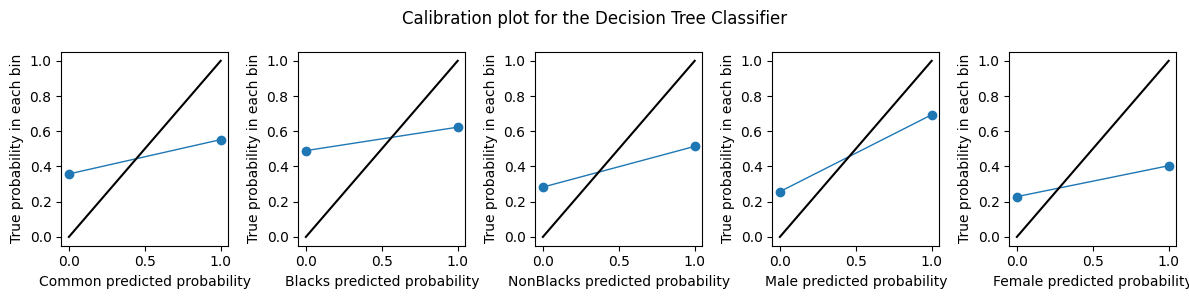

In [44]:
labels_predict = dectr.predict(features_test)
prob_true, prob_pred = calibration_curve(labels_test, labels_predict, n_bins=10)

labels_predict_black = dectr.predict(features_test_black)
prob_true_black, prob_pred_black = calibration_curve(labels_test_black, labels_predict_black, n_bins=10)

labels_predict_nonblack  = dectr.predict(features_test_nonblack)
prob_true_nonblack, prob_pred_nonblack = calibration_curve(labels_test_nonblack, labels_predict_nonblack, n_bins=10)

labels_predict_male = dectr.predict(features_test_male)
prob_true_male, prob_pred_male = calibration_curve(labels_test_male, labels_predict_male, n_bins=10)

labels_predict_female = dectr.predict(features_test_female)
prob_true_female, prob_pred_female = calibration_curve(labels_test_female, labels_predict_female, n_bins=10)

fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(12, 3))
fig.suptitle('Calibration plot for the Decision Tree Classifier')

ax1.plot(prob_pred, prob_true, marker='o', linewidth=1)
ax1.set_xlabel('Common predicted probability')
ax2.plot(prob_pred_black, prob_true_black, marker='o', linewidth=1)
ax2.set_xlabel('Blacks predicted probability')
ax3.plot(prob_pred_nonblack, prob_true_nonblack, marker='o', linewidth=1)
ax3.set_xlabel('NonBlacks predicted probability')
ax4.plot(prob_pred_male, prob_true_male, marker='o', linewidth=1)
ax4.set_xlabel('Male predicted probability')
ax5.plot(prob_pred_female, prob_true_female, marker='o', linewidth=1)
ax5.set_xlabel('Female predicted probability')

for ax in fig.get_axes():
  ax.set_ylabel('True probability in each bin')
  ax.add_line(Line2D([0, 1], [0, 1], color='black'))

fig.tight_layout()
fig.show()

### SVMs

Support Vector Machine Classifier accuracy: 0.66948


/tmp/ipykernel_1172224/3766169793.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


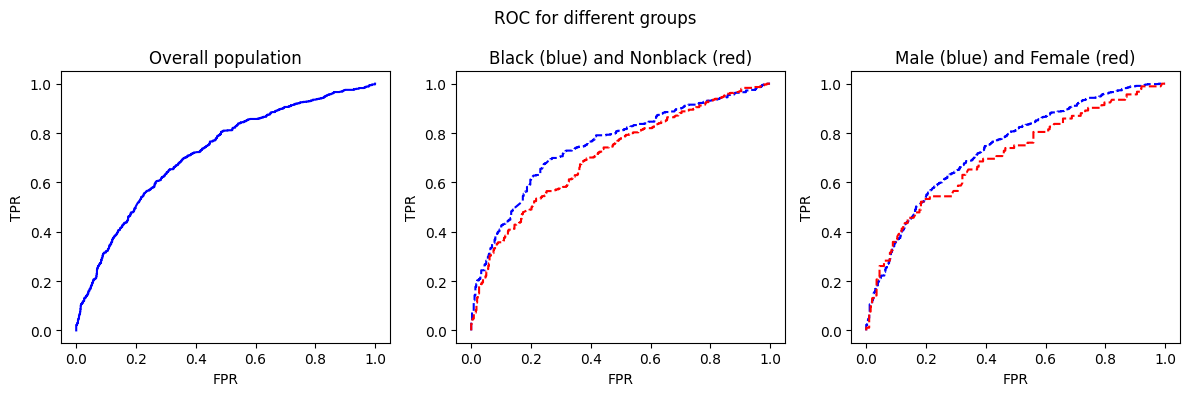

In [45]:
svmc = SVC() 
parameters = [
    {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
    {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
    {'C': [1, 10, 100, 1000], 'kernel': ['poly'], 'degree': [2, 3, 4] ,'gamma': [0.01, 0.02, 0.03, 0.04, 0.05]},
]

grid_search = GridSearchCV(estimator=svmc, param_grid=parameters, scoring='accuracy', cv=5, verbose=0)
grid_search.fit(features_train, labels_train)

svmc = SVC(**grid_search.best_params_, probability=True).fit(features_train, labels_train)
print(f"Support Vector Machine Classifier accuracy: {round(svmc.score(features_test, labels_test), 5)}")

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle('ROC for different groups')

scores = svmc.predict_proba(features_test)
fpr, tpr, thresholds = roc_curve(labels_test, scores[:,1])
ax1.plot(fpr, tpr, 'b')
ax1.set_title('Overall population')
ax1.set_xlabel("FPR")
ax1.set_ylabel("TPR")

scores_black = svmc.predict_proba(features_test_black)
fpr_black, tpr_black, thresholds_black = roc_curve(labels_test_black, scores_black[:,1])
scores_nonblack = svmc.predict_proba(features_test_nonblack)
fpr_nonblack, tpr_nonblack, thresholds_nonblack = roc_curve(labels_test_nonblack, scores_nonblack[:,1])
ax2.plot(fpr_black, tpr_black, 'b--', fpr_nonblack, tpr_nonblack, 'r--')
ax2.set_title('Black (blue) and Nonblack (red)')
ax2.set_xlabel("FPR")
ax2.set_ylabel("TPR")

scores_male = svmc.predict_proba(features_test_male)
fpr_male, tpr_male, thresholds_male = roc_curve(labels_test_male, scores_male[:,1])
scores_female = svmc.predict_proba(features_test_female)
fpr_female, tpr_female, thresholds_female = roc_curve(labels_test_female, scores_female[:,1])
ax3.plot(fpr_male, tpr_male, 'b--', fpr_female, tpr_female, 'r--')
ax3.set_title('Male (blue) and Female (red)')
ax3.set_xlabel("FPR")
ax3.set_ylabel("TPR")

fig.tight_layout()
fig.show()

/tmp/ipykernel_1172224/3712995940.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


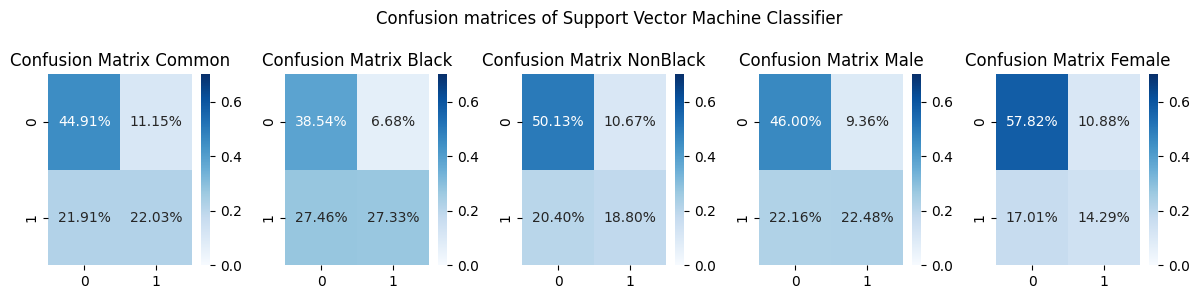

In [46]:
threshold_common = 0.5

def calculate_confusion_matrix(scores, labels_test):
  y_pred_with_threshold = (scores >= threshold_common).astype(int)
  y_pred_with_threshold = np.argmax(y_pred_with_threshold, axis=1)
  return confusion_matrix(labels_test, y_pred_with_threshold)

cm = calculate_confusion_matrix(scores, labels_test)
cm_black = calculate_confusion_matrix(scores_black, labels_test_black)
cm_nonblack = calculate_confusion_matrix(scores_nonblack, labels_test_nonblack)
cm_male = calculate_confusion_matrix(scores_male, labels_test_male)
cm_female = calculate_confusion_matrix(scores_female, labels_test_female)

fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(12, 3))
fig.suptitle('Confusion matrices of Support Vector Machine Classifier')

sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues', ax=ax1, vmin=0.0, vmax=0.7)
ax1.set_title("Confusion Matrix Common")
sns.heatmap(cm_black / np.sum(cm_black), annot=True, fmt='.2%', cmap='Blues', ax=ax2, vmin=0.0, vmax=0.7)
ax2.set_title("Confusion Matrix Black")
sns.heatmap(cm_nonblack / np.sum(cm_nonblack), annot=True, fmt='.2%', cmap='Blues', ax=ax3, vmin=0.0, vmax=0.7)
ax3.set_title("Confusion Matrix NonBlack")
sns.heatmap(cm_male / np.sum(cm_male), annot=True, fmt='.2%', cmap='Blues', ax=ax4, vmin=0.0, vmax=0.7)
ax4.set_title("Confusion Matrix Male")
sns.heatmap(cm_female / np.sum(cm_female), annot=True, fmt='.2%', cmap='Blues', ax=ax5, vmin=0.0, vmax=0.7)
ax5.set_title("Confusion Matrix Female")

for ax in fig.get_axes():
  ax.label_outer()

fig.tight_layout()
fig.show()

/tmp/ipykernel_1172224/1086068629.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


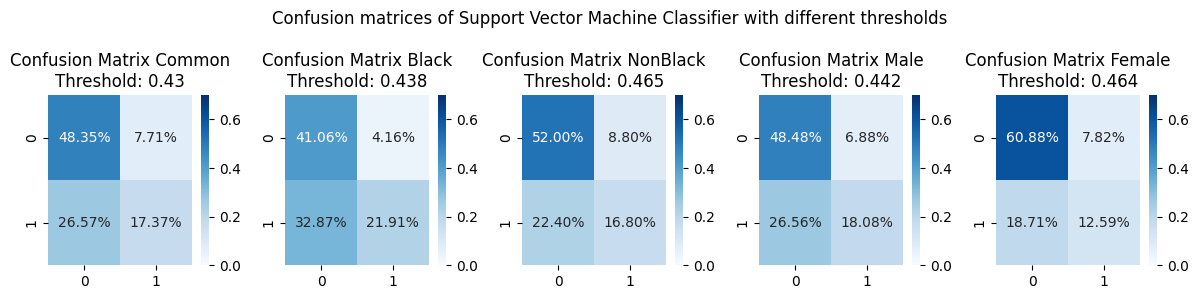

In [47]:
def calculate_confusion_matrix_no_threshhold(scores, features_test, labels_test):
  y_scores = svmc.predict_proba(features_test)[:, 1]
  fpr, tpr, thresholds = roc_curve(labels_test, y_scores)
  optimal_threshold = thresholds[np.argmax(tpr - fpr)]
  y_pred_with_threshold = (scores >= optimal_threshold).astype(int)
  y_pred_with_threshold = np.argmax(y_pred_with_threshold, axis=1)
  return confusion_matrix(labels_test, y_pred_with_threshold), optimal_threshold

cm, th = calculate_confusion_matrix_no_threshhold(scores, features_test, labels_test)
cm_black, th_black = calculate_confusion_matrix_no_threshhold(scores_black, features_test_black, labels_test_black)
cm_nonblack, th_nonblack = calculate_confusion_matrix_no_threshhold(scores_nonblack, features_test_nonblack, labels_test_nonblack)
cm_male, th_male = calculate_confusion_matrix_no_threshhold(scores_male, features_test_male, labels_test_male)
cm_female, th_female = calculate_confusion_matrix_no_threshhold(scores_female, features_test_female, labels_test_female)

fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(12, 3))
fig.suptitle('Confusion matrices of Support Vector Machine Classifier with different thresholds')

sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues', ax=ax1, vmin=0.0, vmax=0.7)
ax1.set_title(f"Confusion Matrix Common\nThreshold: {round(th, 3)}")
sns.heatmap(cm_black / np.sum(cm_black), annot=True, fmt='.2%', cmap='Blues', ax=ax2, vmin=0.0, vmax=0.7)
ax2.set_title(f"Confusion Matrix Black\nThreshold: {round(th_black, 3)}")
sns.heatmap(cm_nonblack / np.sum(cm_nonblack), annot=True, fmt='.2%', cmap='Blues', ax=ax3, vmin=0.0, vmax=0.7)
ax3.set_title(f"Confusion Matrix NonBlack\nThreshold: {round(th_nonblack, 3)}")
sns.heatmap(cm_male / np.sum(cm_male), annot=True, fmt='.2%', cmap='Blues', ax=ax4, vmin=0.0, vmax=0.7)
ax4.set_title(f"Confusion Matrix Male\nThreshold: {round(th_male, 3)}")
sns.heatmap(cm_female / np.sum(cm_female), annot=True, fmt='.2%', cmap='Blues', ax=ax5, vmin=0.0, vmax=0.7)
ax5.set_title(f"Confusion Matrix Female\nThreshold: {round(th_female, 3)}")

for ax in fig.get_axes():
  ax.label_outer()

fig.tight_layout()
fig.show()

/tmp/ipykernel_1172224/3632059065.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


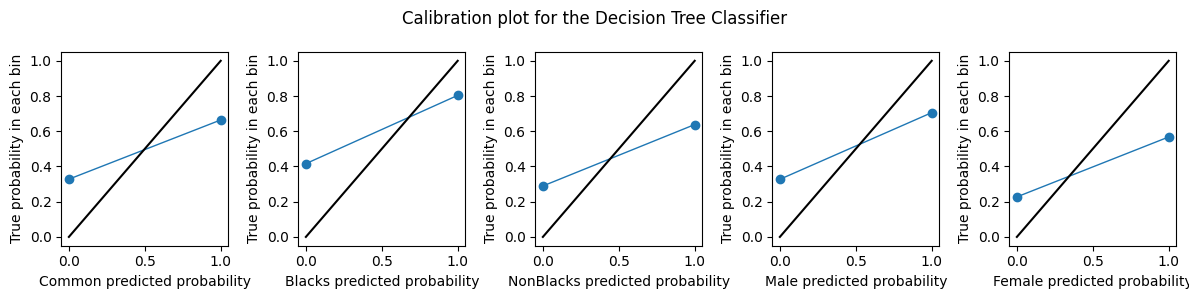

In [48]:
labels_predict = svmc.predict(features_test)
prob_true, prob_pred = calibration_curve(labels_test, labels_predict, n_bins=10)

labels_predict_black = svmc.predict(features_test_black)
prob_true_black, prob_pred_black = calibration_curve(labels_test_black, labels_predict_black, n_bins=10)

labels_predict_nonblack  = svmc.predict(features_test_nonblack)
prob_true_nonblack, prob_pred_nonblack = calibration_curve(labels_test_nonblack, labels_predict_nonblack, n_bins=10)

labels_predict_male = svmc.predict(features_test_male)
prob_true_male, prob_pred_male = calibration_curve(labels_test_male, labels_predict_male, n_bins=10)

labels_predict_female = svmc.predict(features_test_female)
prob_true_female, prob_pred_female = calibration_curve(labels_test_female, labels_predict_female, n_bins=10)

fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(12, 3))
fig.suptitle('Calibration plot for the Decision Tree Classifier')

ax1.plot(prob_pred, prob_true, marker='o', linewidth=1)
ax1.set_xlabel('Common predicted probability')
ax2.plot(prob_pred_black, prob_true_black, marker='o', linewidth=1)
ax2.set_xlabel('Blacks predicted probability')
ax3.plot(prob_pred_nonblack, prob_true_nonblack, marker='o', linewidth=1)
ax3.set_xlabel('NonBlacks predicted probability')
ax4.plot(prob_pred_male, prob_true_male, marker='o', linewidth=1)
ax4.set_xlabel('Male predicted probability')
ax5.plot(prob_pred_female, prob_true_female, marker='o', linewidth=1)
ax5.set_xlabel('Female predicted probability')

for ax in fig.get_axes():
  ax.set_ylabel('True probability in each bin')
  ax.add_line(Line2D([0, 1], [0, 1], color='black'))

fig.tight_layout()
fig.show()

### [Kernel function](https://scikit-learn.org/stable/modules/kernel_approximation.html#radial-basis-function-kernel) Stochastic Gradient Descent

In [49]:
sgdc = SGDClassifier()
parameters = [{
    'alpha': [0.0001, 0.001, 0.01], 
    'l1_ratio': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet', None], 
    'fit_intercept': [True, False], 
    'max_iter': [10000],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
}]

grid_search = GridSearchCV(estimator=sgdc, param_grid=parameters, scoring='accuracy', cv=5, verbose=0)
grid_search.fit(features_train, labels_train)

sgdc = SGDClassifier(**grid_search.best_params_).fit(features_train, labels_train)
print(f"Stochastic Gradient Descent Classifier accuracy: {round(sgdc.score(features_test, labels_test), 5)}")

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle('ROC for different groups')

scores = sgdc.predict_proba(features_test)
fpr, tpr, thresholds = roc_curve(labels_test, scores[:,1])
ax1.plot(fpr, tpr, 'b')
ax1.set_title('Overall population')
ax1.set_xlabel("FPR")
ax1.set_ylabel("TPR")

scores_black = sgdc.predict_proba(features_test_black)
fpr_black, tpr_black, thresholds_black = roc_curve(labels_test_black, scores_black[:,1])
scores_nonblack = sgdc.predict_proba(features_test_nonblack)
fpr_nonblack, tpr_nonblack, thresholds_nonblack = roc_curve(labels_test_nonblack, scores_nonblack[:,1])
ax2.plot(fpr_black, tpr_black, 'b--', fpr_nonblack, tpr_nonblack, 'r--')
ax2.set_title('Black (blue) and Nonblack (red)')
ax2.set_xlabel("FPR")
ax2.set_ylabel("TPR")

scores_male = sgdc.predict_proba(features_test_male)
fpr_male, tpr_male, thresholds_male = roc_curve(labels_test_male, scores_male[:,1])
scores_female = sgdc.predict_proba(features_test_female)
fpr_female, tpr_female, thresholds_female = roc_curve(labels_test_female, scores_female[:,1])
ax3.plot(fpr_male, tpr_male, 'b--', fpr_female, tpr_female, 'r--')
ax3.set_title('Male (blue) and Female (red)')
ax3.set_xlabel("FPR")
ax3.set_ylabel("TPR")

fig.tight_layout()
fig.show()

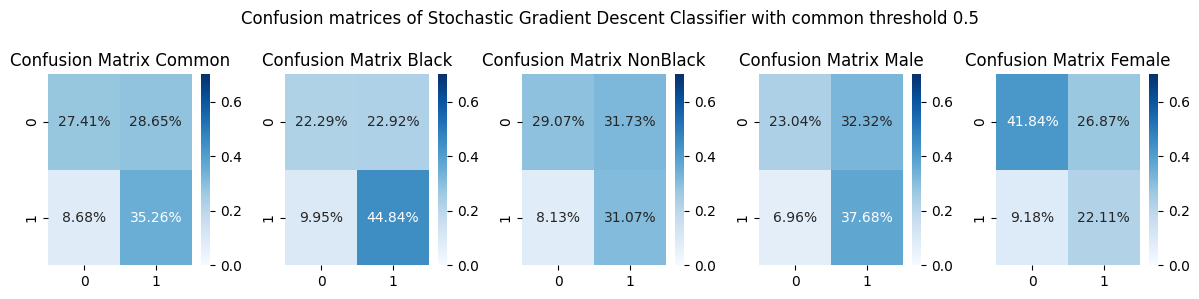

In [ ]:
threshold_common = 0.5

def calculate_confusion_matrix(scores, labels_test):
  y_pred_with_threshold = (scores >= threshold_common).astype(int)
  y_pred_with_threshold = np.argmax(y_pred_with_threshold, axis=1)
  return confusion_matrix(labels_test, y_pred_with_threshold)

cm = calculate_confusion_matrix(scores, labels_test)
cm_black = calculate_confusion_matrix(scores_black, labels_test_black)
cm_nonblack = calculate_confusion_matrix(scores_nonblack, labels_test_nonblack)
cm_male = calculate_confusion_matrix(scores_male, labels_test_male)
cm_female = calculate_confusion_matrix(scores_female, labels_test_female)

fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(12, 3))
fig.suptitle('Confusion matrices of Stochastic Gradient Descent Classifier with common threshold 0.5')

sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues', ax=ax1, vmin=0.0, vmax=0.7)
ax1.set_title("Confusion Matrix Common")
sns.heatmap(cm_black / np.sum(cm_black), annot=True, fmt='.2%', cmap='Blues', ax=ax2, vmin=0.0, vmax=0.7)
ax2.set_title("Confusion Matrix Black")
sns.heatmap(cm_nonblack / np.sum(cm_nonblack), annot=True, fmt='.2%', cmap='Blues', ax=ax3, vmin=0.0, vmax=0.7)
ax3.set_title("Confusion Matrix NonBlack")
sns.heatmap(cm_male / np.sum(cm_male), annot=True, fmt='.2%', cmap='Blues', ax=ax4, vmin=0.0, vmax=0.7)
ax4.set_title("Confusion Matrix Male")
sns.heatmap(cm_female / np.sum(cm_female), annot=True, fmt='.2%', cmap='Blues', ax=ax5, vmin=0.0, vmax=0.7)
ax5.set_title("Confusion Matrix Female")

for ax in fig.get_axes():
  ax.label_outer()

fig.tight_layout()
fig.show()

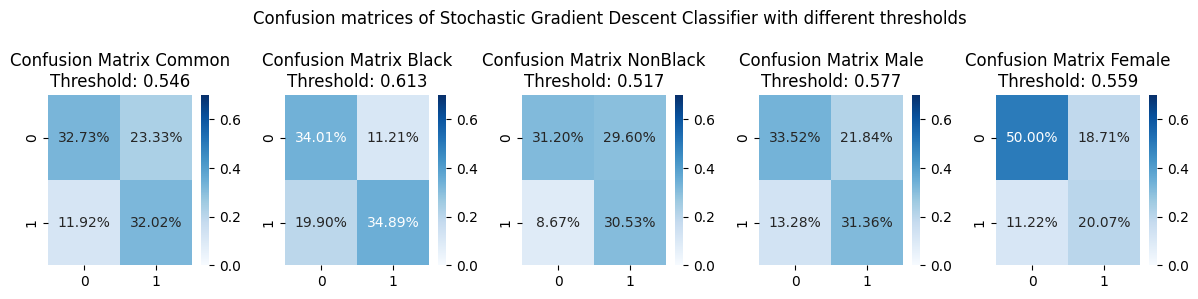

In [ ]:
def calculate_confusion_matrix_no_threshhold(scores, features_test, labels_test):
  y_scores = sgdc.predict_proba(features_test)[:, 1]
  fpr, tpr, thresholds = roc_curve(labels_test, y_scores)
  optimal_threshold = thresholds[np.argmax(tpr - fpr)]
  y_pred_with_threshold = (scores >= optimal_threshold).astype(int)
  y_pred_with_threshold = np.argmax(y_pred_with_threshold, axis=1)
  return confusion_matrix(labels_test, y_pred_with_threshold), optimal_threshold

cm, th = calculate_confusion_matrix_no_threshhold(scores, features_test, labels_test)
cm_black, th_black = calculate_confusion_matrix_no_threshhold(scores_black, features_test_black, labels_test_black)
cm_nonblack, th_nonblack = calculate_confusion_matrix_no_threshhold(scores_nonblack, features_test_nonblack, labels_test_nonblack)
cm_male, th_male = calculate_confusion_matrix_no_threshhold(scores_male, features_test_male, labels_test_male)
cm_female, th_female = calculate_confusion_matrix_no_threshhold(scores_female, features_test_female, labels_test_female)

fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(12, 3))
fig.suptitle('Confusion matrices of Stochastic Gradient Descent Classifier with different thresholds')

sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues', ax=ax1, vmin=0.0, vmax=0.7)
ax1.set_title(f"Confusion Matrix Common\nThreshold: {round(th, 3)}")
sns.heatmap(cm_black / np.sum(cm_black), annot=True, fmt='.2%', cmap='Blues', ax=ax2, vmin=0.0, vmax=0.7)
ax2.set_title(f"Confusion Matrix Black\nThreshold: {round(th_black, 3)}")
sns.heatmap(cm_nonblack / np.sum(cm_nonblack), annot=True, fmt='.2%', cmap='Blues', ax=ax3, vmin=0.0, vmax=0.7)
ax3.set_title(f"Confusion Matrix NonBlack\nThreshold: {round(th_nonblack, 3)}")
sns.heatmap(cm_male / np.sum(cm_male), annot=True, fmt='.2%', cmap='Blues', ax=ax4, vmin=0.0, vmax=0.7)
ax4.set_title(f"Confusion Matrix Male\nThreshold: {round(th_male, 3)}")
sns.heatmap(cm_female / np.sum(cm_female), annot=True, fmt='.2%', cmap='Blues', ax=ax5, vmin=0.0, vmax=0.7)
ax5.set_title(f"Confusion Matrix Female\nThreshold: {round(th_female, 3)}")

for ax in fig.get_axes():
  ax.label_outer()

fig.tight_layout()
fig.show()

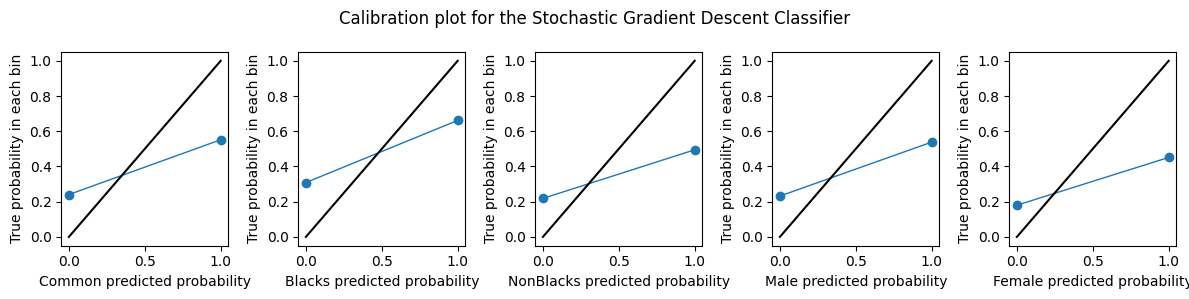

In [ ]:
labels_predict = sgdc.predict(features_test)
prob_true, prob_pred = calibration_curve(labels_test, labels_predict, n_bins=10)

labels_predict_black = sgdc.predict(features_test_black)
prob_true_black, prob_pred_black = calibration_curve(labels_test_black, labels_predict_black, n_bins=10)

labels_predict_nonblack  = sgdc.predict(features_test_nonblack)
prob_true_nonblack, prob_pred_nonblack = calibration_curve(labels_test_nonblack, labels_predict_nonblack, n_bins=10)

labels_predict_male = sgdc.predict(features_test_male)
prob_true_male, prob_pred_male = calibration_curve(labels_test_male, labels_predict_male, n_bins=10)

labels_predict_female = sgdc.predict(features_test_female)
prob_true_female, prob_pred_female = calibration_curve(labels_test_female, labels_predict_female, n_bins=10)

fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(12, 3))
fig.suptitle('Calibration plot for the Stochastic Gradient Descent Classifier')

ax1.plot(prob_pred, prob_true, marker='o', linewidth=1)
ax1.set_xlabel('Common predicted probability')
ax2.plot(prob_pred_black, prob_true_black, marker='o', linewidth=1)
ax2.set_xlabel('Blacks predicted probability')
ax3.plot(prob_pred_nonblack, prob_true_nonblack, marker='o', linewidth=1)
ax3.set_xlabel('NonBlacks predicted probability')
ax4.plot(prob_pred_male, prob_true_male, marker='o', linewidth=1)
ax4.set_xlabel('Male predicted probability')
ax5.plot(prob_pred_female, prob_true_female, marker='o', linewidth=1)
ax5.set_xlabel('Female predicted probability')

for ax in fig.get_axes():
  ax.set_ylabel('True probability in each bin')
  ax.add_line(Line2D([0, 1], [0, 1], color='black'))

fig.tight_layout()
fig.show()

### Neural Network

Neural Network Classifier accuracy: 0.67596


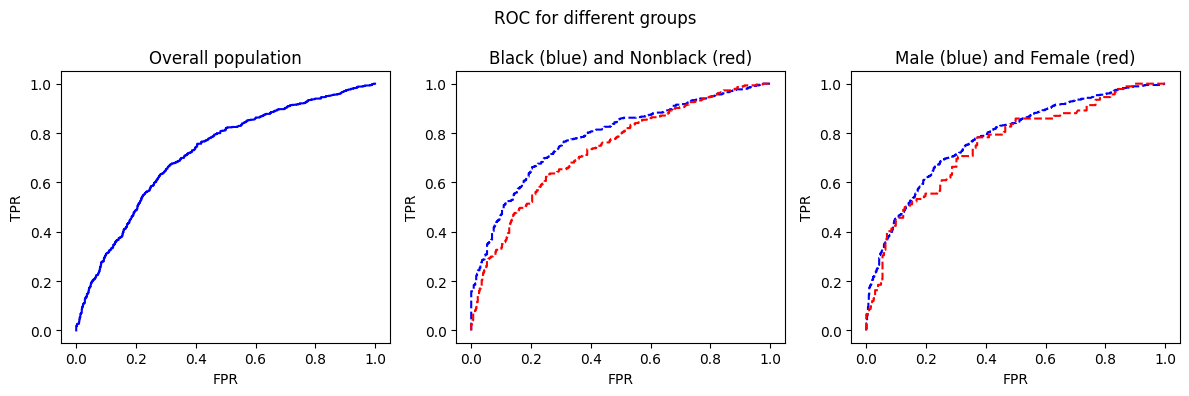

In [ ]:
mlpc = MLPClassifier(hidden_layer_sizes=1000, learning_rate='adaptive', max_iter=5000).fit(features_train, labels_train)
print(f"Neural Network Classifier accuracy: {round(mlpc.score(features_test, labels_test), 5)}")

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle('ROC for different groups')

scores = mlpc.predict_proba(features_test)
fpr, tpr, thresholds = roc_curve(labels_test, scores[:,1])
ax1.plot(fpr, tpr, 'b')
ax1.set_title('Overall population')
ax1.set_xlabel("FPR")
ax1.set_ylabel("TPR")

scores_black = mlpc.predict_proba(features_test_black)
fpr_black, tpr_black, thresholds_black = roc_curve(labels_test_black, scores_black[:,1])
scores_nonblack = mlpc.predict_proba(features_test_nonblack)
fpr_nonblack, tpr_nonblack, thresholds_nonblack = roc_curve(labels_test_nonblack, scores_nonblack[:,1])
ax2.plot(fpr_black, tpr_black, 'b--', fpr_nonblack, tpr_nonblack, 'r--')
ax2.set_title('Black (blue) and Nonblack (red)')
ax2.set_xlabel("FPR")
ax2.set_ylabel("TPR")

scores_male = mlpc.predict_proba(features_test_male)
fpr_male, tpr_male, thresholds_male = roc_curve(labels_test_male, scores_male[:,1])
scores_female = mlpc.predict_proba(features_test_female)
fpr_female, tpr_female, thresholds_female = roc_curve(labels_test_female, scores_female[:,1])
ax3.plot(fpr_male, tpr_male, 'b--', fpr_female, tpr_female, 'r--')
ax3.set_title('Male (blue) and Female (red)')
ax3.set_xlabel("FPR")
ax3.set_ylabel("TPR")

fig.tight_layout()
fig.show()

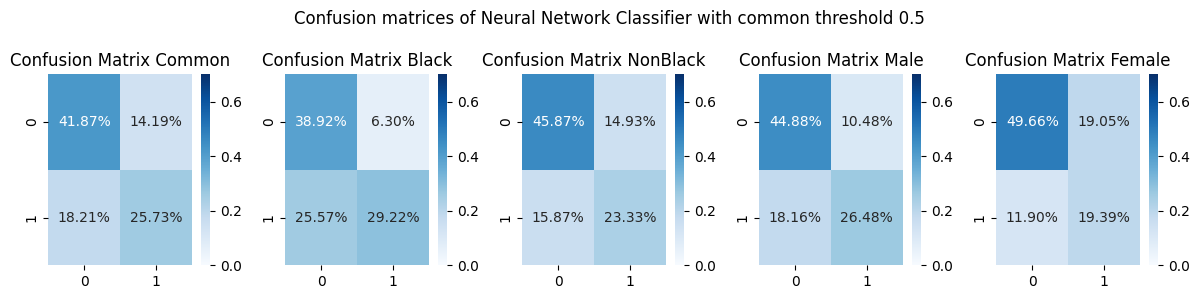

In [ ]:
threshold_common = 0.5

def calculate_confusion_matrix(scores, labels_test):
  y_pred_with_threshold = (scores >= threshold_common).astype(int)
  y_pred_with_threshold = np.argmax(y_pred_with_threshold, axis=1)
  return confusion_matrix(labels_test, y_pred_with_threshold)

cm = calculate_confusion_matrix(scores, labels_test)
cm_black = calculate_confusion_matrix(scores_black, labels_test_black)
cm_nonblack = calculate_confusion_matrix(scores_nonblack, labels_test_nonblack)
cm_male = calculate_confusion_matrix(scores_male, labels_test_male)
cm_female = calculate_confusion_matrix(scores_female, labels_test_female)

fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(12, 3))
fig.suptitle('Confusion matrices of Neural Network Classifier with common threshold 0.5')

sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues', ax=ax1, vmin=0.0, vmax=0.7)
ax1.set_title("Confusion Matrix Common")
sns.heatmap(cm_black / np.sum(cm_black), annot=True, fmt='.2%', cmap='Blues', ax=ax2, vmin=0.0, vmax=0.7)
ax2.set_title("Confusion Matrix Black")
sns.heatmap(cm_nonblack / np.sum(cm_nonblack), annot=True, fmt='.2%', cmap='Blues', ax=ax3, vmin=0.0, vmax=0.7)
ax3.set_title("Confusion Matrix NonBlack")
sns.heatmap(cm_male / np.sum(cm_male), annot=True, fmt='.2%', cmap='Blues', ax=ax4, vmin=0.0, vmax=0.7)
ax4.set_title("Confusion Matrix Male")
sns.heatmap(cm_female / np.sum(cm_female), annot=True, fmt='.2%', cmap='Blues', ax=ax5, vmin=0.0, vmax=0.7)
ax5.set_title("Confusion Matrix Female")

for ax in fig.get_axes():
  ax.label_outer()

fig.tight_layout()
fig.show()

### Equalized Odds
Given a score function, how can we choose the threshold so that it satisfies **equalized odds**?  Recall that Equalized Odds requires parity of FNR/FPR across groups. So if we now look at the intersection of the two ROC curves for two attributes, this now describes exactly the case. However, the threshold is then no longer necessarily optimal. Now let ta or tb be this intersection point on the different curves.

$$
  F(x,c) =\begin{cases}
    0, & \text{if  $S|a(x) < t_a$ and $c=a$ }\\
    0, & \text{if  $S|b(x) < t_b$ and $c=b$ }\\
    1, & \text{if  $S|a(x) >= t_a$ and $c=a$}\\
    1, & \text{if  $S|b(x) >= t_b$ and $c=b$}
  \end{cases}
$$



In [ ]:
labels_predict_black = mlpc.predict(features_test_black)
labels_predict_nonblack = mlpc.predict(features_test_nonblack)

fpr_b, tpr_b, thresholds_b = roc_curve(labels_test_black, labels_predict_black) 
fpr, tpr, thresholds_nb = roc_curve(labels_test_nonblack, labels_predict_nonblack) 
 
df_black = pd.DataFrame({'fpr': fpr_b, 'tpr': tpr_b, 'thresholds_b' : thresholds_b})
df_nonblack = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresholds_nb': thresholds_nb})

intersection_points = pd.merge(df_black.round(3), df_nonblack.round(3), how='inner', on=['fpr', 'tpr'])
intersection_points

,fpr,tpr,thresholds_b,thresholds_nb
0,0.0,0.0,2,2
1,1.0,1.0,0,0


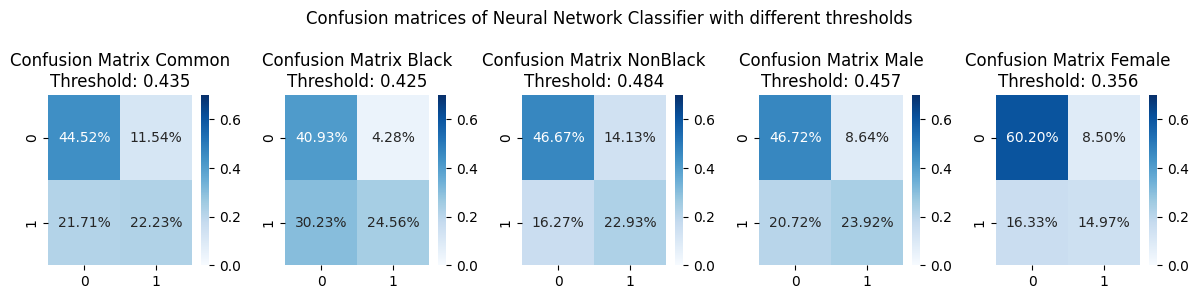

In [ ]:
def calculate_confusion_matrix_no_threshhold(scores, features_test, labels_test):
  y_scores = mlpc.predict_proba(features_test)[:, 1]
  fpr, tpr, thresholds = roc_curve(labels_test, y_scores)
  optimal_threshold = thresholds[np.argmax(tpr - fpr)]
  y_pred_with_threshold = (scores >= optimal_threshold).astype(int)
  y_pred_with_threshold = np.argmax(y_pred_with_threshold, axis=1)
  return confusion_matrix(labels_test, y_pred_with_threshold), optimal_threshold

cm, th = calculate_confusion_matrix_no_threshhold(scores, features_test, labels_test)
cm_black, th_black = calculate_confusion_matrix_no_threshhold(scores_black, features_test_black, labels_test_black)
cm_nonblack, th_nonblack = calculate_confusion_matrix_no_threshhold(scores_nonblack, features_test_nonblack, labels_test_nonblack)
cm_male, th_male = calculate_confusion_matrix_no_threshhold(scores_male, features_test_male, labels_test_male)
cm_female, th_female = calculate_confusion_matrix_no_threshhold(scores_female, features_test_female, labels_test_female)

fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(12, 3))
fig.suptitle('Confusion matrices of Neural Network Classifier with different thresholds')

sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues', ax=ax1, vmin=0.0, vmax=0.7)
ax1.set_title(f"Confusion Matrix Common\nThreshold: {round(th, 3)}")
sns.heatmap(cm_black / np.sum(cm_black), annot=True, fmt='.2%', cmap='Blues', ax=ax2, vmin=0.0, vmax=0.7)
ax2.set_title(f"Confusion Matrix Black\nThreshold: {round(th_black, 3)}")
sns.heatmap(cm_nonblack / np.sum(cm_nonblack), annot=True, fmt='.2%', cmap='Blues', ax=ax3, vmin=0.0, vmax=0.7)
ax3.set_title(f"Confusion Matrix NonBlack\nThreshold: {round(th_nonblack, 3)}")
sns.heatmap(cm_male / np.sum(cm_male), annot=True, fmt='.2%', cmap='Blues', ax=ax4, vmin=0.0, vmax=0.7)
ax4.set_title(f"Confusion Matrix Male\nThreshold: {round(th_male, 3)}")
sns.heatmap(cm_female / np.sum(cm_female), annot=True, fmt='.2%', cmap='Blues', ax=ax5, vmin=0.0, vmax=0.7)
ax5.set_title(f"Confusion Matrix Female\nThreshold: {round(th_female, 3)}")

for ax in fig.get_axes():
  ax.label_outer()

fig.tight_layout()
fig.show()

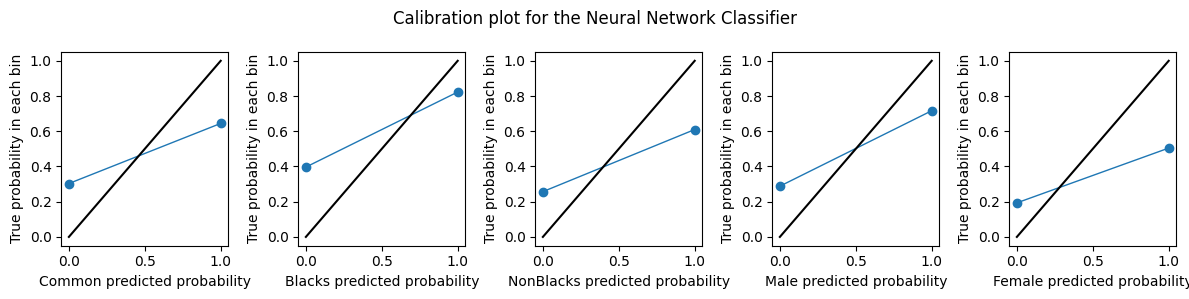

In [ ]:
labels_predict = mlpc.predict(features_test)
prob_true, prob_pred = calibration_curve(labels_test, labels_predict, n_bins=10)

labels_predict_black = mlpc.predict(features_test_black)
prob_true_black, prob_pred_black = calibration_curve(labels_test_black, labels_predict_black, n_bins=10)

labels_predict_nonblack  = mlpc.predict(features_test_nonblack)
prob_true_nonblack, prob_pred_nonblack = calibration_curve(labels_test_nonblack, labels_predict_nonblack, n_bins=10)

labels_predict_male = mlpc.predict(features_test_male)
prob_true_male, prob_pred_male = calibration_curve(labels_test_male, labels_predict_male, n_bins=10)

labels_predict_female = mlpc.predict(features_test_female)
prob_true_female, prob_pred_female = calibration_curve(labels_test_female, labels_predict_female, n_bins=10)

fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(12, 3))
fig.suptitle('Calibration plot for the Neural Network Classifier')

ax1.plot(prob_pred, prob_true, marker='o', linewidth=1)
ax1.set_xlabel('Common predicted probability')
ax2.plot(prob_pred_black, prob_true_black, marker='o', linewidth=1)
ax2.set_xlabel('Blacks predicted probability')
ax3.plot(prob_pred_nonblack, prob_true_nonblack, marker='o', linewidth=1)
ax3.set_xlabel('NonBlacks predicted probability')
ax4.plot(prob_pred_male, prob_true_male, marker='o', linewidth=1)
ax4.set_xlabel('Male predicted probability')
ax5.plot(prob_pred_female, prob_true_female, marker='o', linewidth=1)
ax5.set_xlabel('Female predicted probability')

for ax in fig.get_axes():
  ax.set_ylabel('True probability in each bin')
  ax.add_line(Line2D([0, 1], [0, 1], color='black'))

fig.tight_layout()
fig.show()

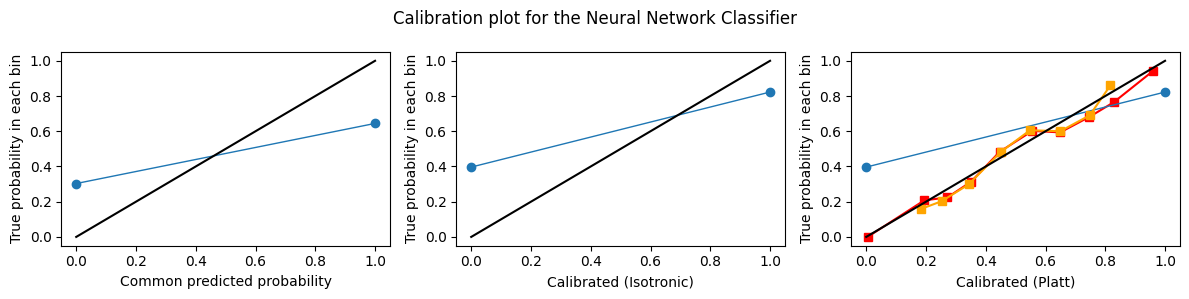

In [ ]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(12, 3))
fig.suptitle('Calibration plot for the Neural Network Classifier')
ax1.plot(prob_pred, prob_true, marker='o', linewidth=1)
ax1.set_xlabel('Common predicted probability')

# Calibrated
clf_sigmoid = CalibratedClassifierCV(mlpc, cv=3, method='isotonic')
clf_sigmoid.fit(features_train, labels_train)
y_test_predict_proba = clf_sigmoid.predict_proba(features_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(labels_test, y_test_predict_proba, n_bins=10)


ax2.plot(prob_pred_black, prob_true_black, marker='o', linewidth=1)
ax2.set_xlabel('Calibrated (Isotronic)')
plt.plot(mean_predicted_value, fraction_of_positives, 's-', color='red', label='Calibrated (Isotonic)')

# Calibrated, Platt
clf_sigmoid = CalibratedClassifierCV(mlpc, cv=3, method='sigmoid')
clf_sigmoid.fit(features_train, labels_train)
y_test_predict_proba = clf_sigmoid.predict_proba(features_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(labels_test, y_test_predict_proba, n_bins=10)

ax3.plot(prob_pred_black, prob_true_black, marker='o', linewidth=1)
ax3.set_xlabel('Calibrated (Platt)')
plt.plot(mean_predicted_value, fraction_of_positives, 's-', color='orange', label='Calibrated (Platt)')

for ax in fig.get_axes():
  ax.set_ylabel('True probability in each bin')
  ax.add_line(Line2D([0, 1], [0, 1], color='black'))

fig.tight_layout()
fig.show()

In [ ]:
labels_predict = clf_sigmoid.predict(features_test)
prob_true, prob_pred = calibration_curve(labels_test, labels_predict, n_bins=10)

labels_predict_black = clf_sigmoid.predict(features_test_black)
prob_true_black, prob_pred_black = calibration_curve(labels_test_black, labels_predict_black, n_bins=10)

labels_predict_nonblack  = clf_sigmoid.predict(features_test_nonblack)
prob_true_nonblack, prob_pred_nonblack = calibration_curve(labels_test_nonblack, labels_predict_nonblack, n_bins=10)

labels_predict_male = clf_sigmoid.predict(features_test_male)
prob_true_male, prob_pred_male = calibration_curve(labels_test_male, labels_predict_male, n_bins=10)

labels_predict_female = clf_sigmoid.predict(features_test_female)
prob_true_female, prob_pred_female = calibration_curve(labels_test_female, labels_predict_female, n_bins=10)

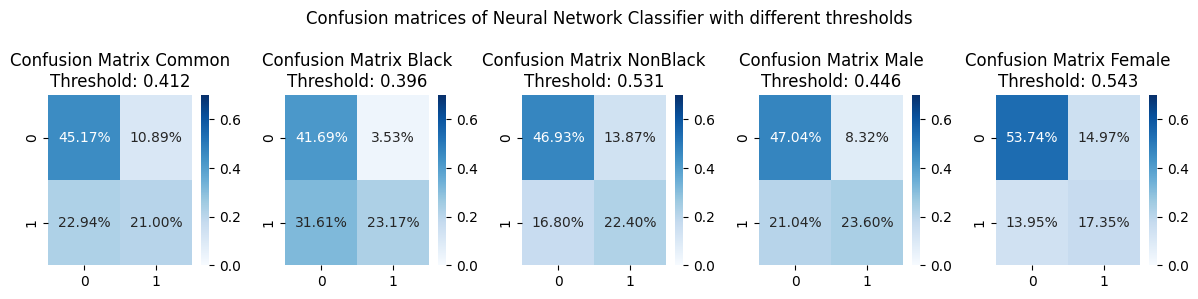

In [ ]:
def calculate_confusion_matrix_no_threshhold(scores, features_test, labels_test):
  y_scores = clf_sigmoid.predict_proba(features_test)[:, 1]
  fpr, tpr, thresholds = roc_curve(labels_test, y_scores)
  optimal_threshold = thresholds[np.argmax(tpr - fpr)]
  y_pred_with_threshold = (scores >= optimal_threshold).astype(int)
  y_pred_with_threshold = np.argmax(y_pred_with_threshold, axis=1)
  return confusion_matrix(labels_test, y_pred_with_threshold), optimal_threshold

cm, th = calculate_confusion_matrix_no_threshhold(scores, features_test, labels_test)
cm_black, th_black = calculate_confusion_matrix_no_threshhold(scores_black, features_test_black, labels_test_black)
cm_nonblack, th_nonblack = calculate_confusion_matrix_no_threshhold(scores_nonblack, features_test_nonblack, labels_test_nonblack)
cm_male, th_male = calculate_confusion_matrix_no_threshhold(scores_male, features_test_male, labels_test_male)
cm_female, th_female = calculate_confusion_matrix_no_threshhold(scores_female, features_test_female, labels_test_female)

fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(12, 3))
fig.suptitle('Confusion matrices of Neural Network Classifier with different thresholds')

sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues', ax=ax1, vmin=0.0, vmax=0.7)
ax1.set_title(f"Confusion Matrix Common\nThreshold: {round(th, 3)}")
sns.heatmap(cm_black / np.sum(cm_black), annot=True, fmt='.2%', cmap='Blues', ax=ax2, vmin=0.0, vmax=0.7)
ax2.set_title(f"Confusion Matrix Black\nThreshold: {round(th_black, 3)}")
sns.heatmap(cm_nonblack / np.sum(cm_nonblack), annot=True, fmt='.2%', cmap='Blues', ax=ax3, vmin=0.0, vmax=0.7)
ax3.set_title(f"Confusion Matrix NonBlack\nThreshold: {round(th_nonblack, 3)}")
sns.heatmap(cm_male / np.sum(cm_male), annot=True, fmt='.2%', cmap='Blues', ax=ax4, vmin=0.0, vmax=0.7)
ax4.set_title(f"Confusion Matrix Male\nThreshold: {round(th_male, 3)}")
sns.heatmap(cm_female / np.sum(cm_female), annot=True, fmt='.2%', cmap='Blues', ax=ax5, vmin=0.0, vmax=0.7)
ax5.set_title(f"Confusion Matrix Female\nThreshold: {round(th_female, 3)}")

for ax in fig.get_axes():
  ax.label_outer()

fig.tight_layout()
fig.show()


A function is called **calibrated** if the following is satisfied. 

$$ P(Y=1|S=s)=s  $$



Another notion of Fairness **Callibration within groups**
$$ P(Y=1|S=s,A=a)=s,for all s∈R,a∈A $$ 

This will also implies PVP Parity


**Balance for the Postive/Negative Class** 

$$ E[S|Y=1,A=a]=E[S|Y=1,A=b] $$ 
and the same for the negative values. 
We can interpret this of continiuos version of equalized odds.


##Advanced Neural Network
> With `pytorch` and `lightning`

In [ ]:
class ClassificatorModel(LightningModule):
    def __init__(self):
        super().__init__()
        self.loss = BCELoss()
        self.constructor = Linear(15, 500)
        self.activator = ReLU()
        self.reconstructor = Linear(500, 10000)
        self.reactivator = ReLU()
        self.deconstructor = Linear(10000, 500)
        self.deactivator = ReLU()
        self.folder = Linear(500, 1)
        self.wrapper = Sigmoid()

    def forward(self, x):
        x = self.constructor(x)
        x = self.activator(x)
        x = self.reconstructor(x)
        x = self.reactivator(x)
        x = self.deconstructor(x)
        x = self.deactivator(x)
        x = self.folder(x)
        x = self.wrapper(x)
        return x

    def _accuracy(self, x, y):
        return (x.flatten().round() == y).float().mean()

    def score(self, batch):
        x, y = batch
        x = self.forward(x)
        return self._accuracy(x, y)

    def training_step(self, batch, _):
        x, y = batch[0]
        x = self.forward(x)
        loss = self.loss(x, y.unsqueeze(1))
        self.log("train_loss", loss)
        self.log("train_acc", self._accuracy(x, y))
        return loss

    def validation_step(self, batch, _):
        x, y = batch
        x = self.forward(x)
        loss = self.loss(x, y.unsqueeze(1))
        self.log("val_loss", loss)
        self.log("val_acc", (self._accuracy(x, y)))

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=0.001)

In [ ]:
cpus = cpu_count()
batch = round(sqrt(len(labels_train)))

features_train_tensor = FloatTensor(features_train)
labels_train_tensor = FloatTensor(labels_train.to_numpy())
features_test_tensor = FloatTensor(features_test)
labels_test_tensor = FloatTensor(labels_test.to_numpy())

train_dataset = TensorDataset(features_train_tensor, labels_train_tensor)
test_dataset = TensorDataset(features_test_tensor, labels_test_tensor)

train_dataloader = DataLoader(train_dataset, num_workers=cpus, batch_size=batch, shuffle=True)
test_dataloader = DataLoader(test_dataset, num_workers=cpus, batch_size=batch)

In [ ]:
epochs = 100

model = ClassificatorModel()
early_stopping = EarlyStopping(monitor="val_acc", patience=5, verbose=False, mode="max")
trainer = Trainer(max_epochs=epochs, log_every_n_steps=1, logger=CSVLogger("logs"), callbacks=[early_stopping])
trainer.fit(model, train_dataloaders=[train_dataloader], val_dataloaders=[test_dataloader])

print("Average accuracy for neural network algorithm:", round(model.score([features_test_tensor, labels_test_tensor]).item(), 5))

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name          | Type    | Params
------------------------------------------
0 | loss          | BCELoss | 0     
1 | constructor   | Linear  | 8.0 K 
2 | activator     | ReLU    | 0     
3 | reconstructor | Linear  | 5.0 M 
4 | reactivator   | ReLU    | 0     
5 | deconstructor | Linear  | 5.0 M 
6 | deactivator   | ReLU    | 0     
7 | folder        | Linear  | 501   
8 | wrapper       | Sigmoid | 0     
------------------------------------------
10.0 M    Trainable params
0         Non-traina

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Average accuracy for neural network algorithm: 0.68373


##Unsupervised Learning

In [ ]:
from sklearn.cluster import KMeans

number = 250

clusters = dict()
kmc = KMeans(n_init='auto', n_clusters=number, max_iter=500).fit(features_train)
for s, l in zip(features_train, labels_train):
  prediction = kmc.predict([s])[0]
  if prediction not in clusters:
    clusters[prediction] = list()
  clusters[prediction] += [(s, l)]

classifiers = dict()
for cluster, samples in clusters.items():
  samples, labels = list(zip(*samples))
  classifiers[cluster] = MLPClassifier(learning_rate='adaptive', max_iter=5000).fit(samples, labels)

average = dict()
for s, l in zip(features_test, labels_test):
  prediction = kmc.predict([s])[0]
  score = classifiers[prediction].score([s], [l])
  average[prediction] = score

print("Average accuracy for neurale networks on different clusters:", round(sum(average.values()) / len(average), 5))

Average accuracy for neurale networks on different clusters: 0.64583


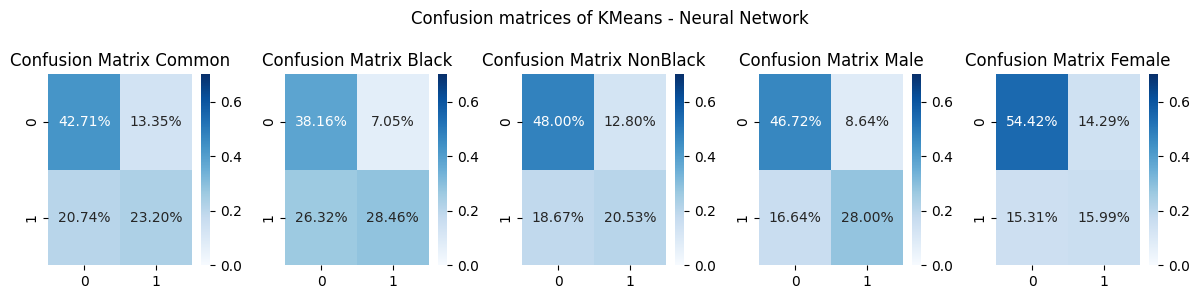

In [ ]:
def predict_proba(x):
  predictions = list()
  for p in x:
    prediction = kmc.predict([p])[0]
    predictions += [classifiers[prediction].predict([p])]
  return np.rint(np.array(predictions, 'f'))

predict = predict_proba(features_test)
predict_black = predict_proba(features_test_black)
predict_nonblack =  predict_proba(features_test_nonblack)
predict_male = predict_proba(features_test_male)
predict_female = predict_proba(features_test_female)

cm = confusion_matrix(labels_test, predict)
cm_black = confusion_matrix(labels_test_black, predict_black)
cm_nonblack = confusion_matrix(labels_test_nonblack, predict_nonblack)
cm_male = confusion_matrix( labels_test_male, predict_male)
cm_female = confusion_matrix(labels_test_female, predict_female)

fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(12, 3))
fig.suptitle('Confusion matrices of KMeans - Neural Network')

sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues', ax=ax1, vmin=0.0, vmax=0.7)
ax1.set_title("Confusion Matrix Common")
sns.heatmap(cm_black / np.sum(cm_black), annot=True, fmt='.2%', cmap='Blues', ax=ax2, vmin=0.0, vmax=0.7)
ax2.set_title("Confusion Matrix Black")
sns.heatmap(cm_nonblack / np.sum(cm_nonblack), annot=True, fmt='.2%', cmap='Blues', ax=ax3, vmin=0.0, vmax=0.7)
ax3.set_title("Confusion Matrix NonBlack")
sns.heatmap(cm_male / np.sum(cm_male), annot=True, fmt='.2%', cmap='Blues', ax=ax4, vmin=0.0, vmax=0.7)
ax4.set_title("Confusion Matrix Male")

sns.heatmap(cm_female / np.sum(cm_female), annot=True, fmt='.2%', cmap='Blues', ax=ax5, vmin=0.0, vmax=0.7)
ax5.set_title("Confusion Matrix Female")

for ax in fig.get_axes():
  ax.label_outer()

fig.tight_layout()
fig.show()

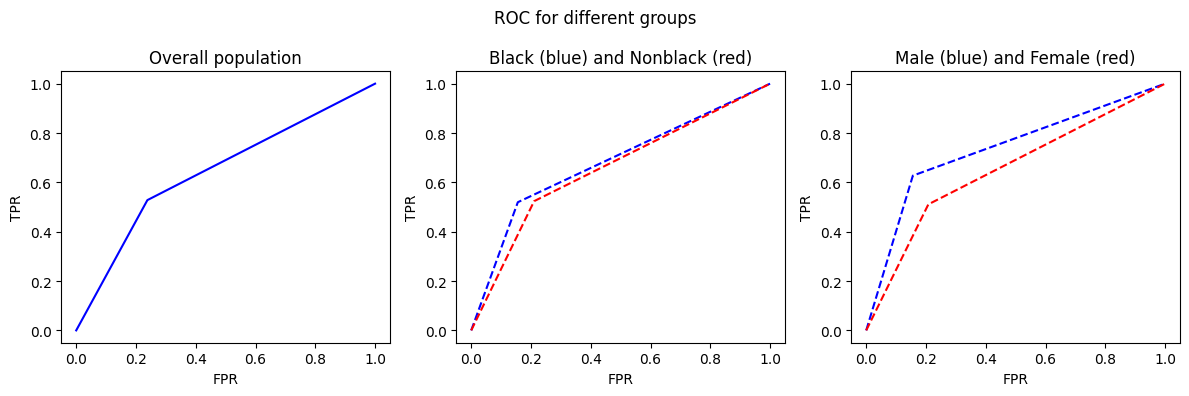

In [ ]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle('ROC for different groups')

scores = predict_proba(features_test)
fpr, tpr, thresholds = roc_curve(labels_test, scores)
ax1.plot(fpr, tpr, 'b')
ax1.set_title('Overall population')
ax1.set_xlabel("FPR")
ax1.set_ylabel("TPR")

scores_black = predict_proba(features_test_black)
fpr_black, tpr_black, thresholds_black = roc_curve(labels_test_black, scores_black)
scores_nonblack = predict_proba(features_test_nonblack)
fpr_nonblack, tpr_nonblack, thresholds_nonblack = roc_curve(labels_test_nonblack, scores_nonblack)
ax2.plot(fpr_black, tpr_black, 'b--', fpr_nonblack, tpr_nonblack, 'r--')
ax2.set_title('Black (blue) and Nonblack (red)')
ax2.set_xlabel("FPR")
ax2.set_ylabel("TPR")

scores_male = predict_proba(features_test_male)
fpr_male, tpr_male, thresholds_male = roc_curve(labels_test_male, scores_male)
scores_female = predict_proba(features_test_female)
fpr_female, tpr_female, thresholds_female = roc_curve(labels_test_female, scores_female)
ax3.plot(fpr_male, tpr_male, 'b--', fpr_female, tpr_female, 'r--')
ax3.set_title('Male (blue) and Female (red)')
ax3.set_xlabel("FPR")
ax3.set_ylabel("TPR")

fig.tight_layout()
fig.show()

## Gradient Boosting Classifier

Gradient Boosting Classifier accuracy: 0.66299


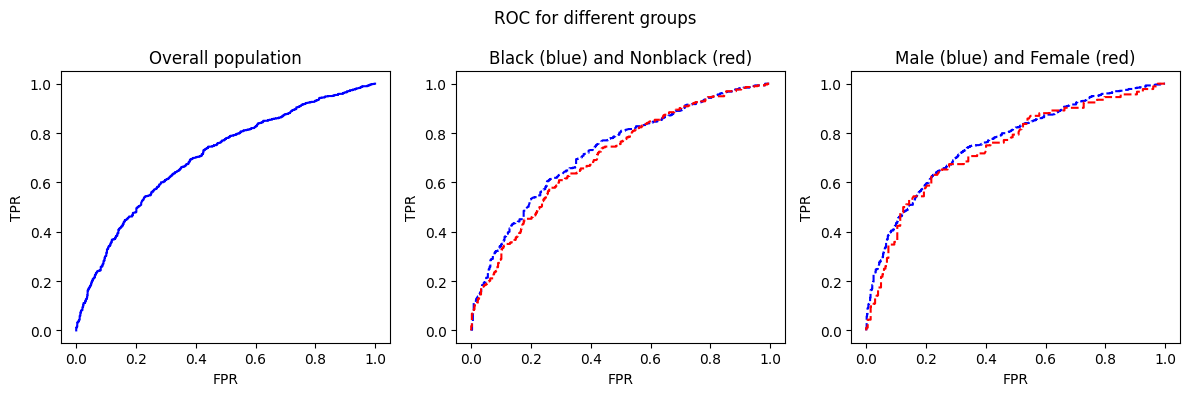

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=1000).fit(features_train, labels_train)
print(f"Gradient Boosting Classifier accuracy: {round(gbc.score(features_test, labels_test), 5)}")

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle('ROC for different groups')

scores = gbc.predict_proba(features_test)
fpr, tpr, thresholds = roc_curve(labels_test, scores[:,1])
ax1.plot(fpr, tpr, 'b')
ax1.set_title('Overall population')
ax1.set_xlabel("FPR")
ax1.set_ylabel("TPR")

scores_black = gbc.predict_proba(features_test_black)
fpr_black, tpr_black, thresholds_black = roc_curve(labels_test_black, scores_black[:,1])
scores_nonblack = gbc.predict_proba(features_test_nonblack)
fpr_nonblack, tpr_nonblack, thresholds_nonblack = roc_curve(labels_test_nonblack, scores_nonblack[:,1])
ax2.plot(fpr_black, tpr_black, 'b--', fpr_nonblack, tpr_nonblack, 'r--')
ax2.set_title('Black (blue) and Nonblack (red)')
ax2.set_xlabel("FPR")
ax2.set_ylabel("TPR")

scores_male = gbc.predict_proba(features_test_male)
fpr_male, tpr_male, thresholds_male = roc_curve(labels_test_male, scores_male[:,1])
scores_female = gbc.predict_proba(features_test_female)
fpr_female, tpr_female, thresholds_female = roc_curve(labels_test_female, scores_female[:,1])
ax3.plot(fpr_male, tpr_male, 'b--', fpr_female, tpr_female, 'r--')
ax3.set_title('Male (blue) and Female (red)')
ax3.set_xlabel("FPR")
ax3.set_ylabel("TPR")

fig.tight_layout()
fig.show()

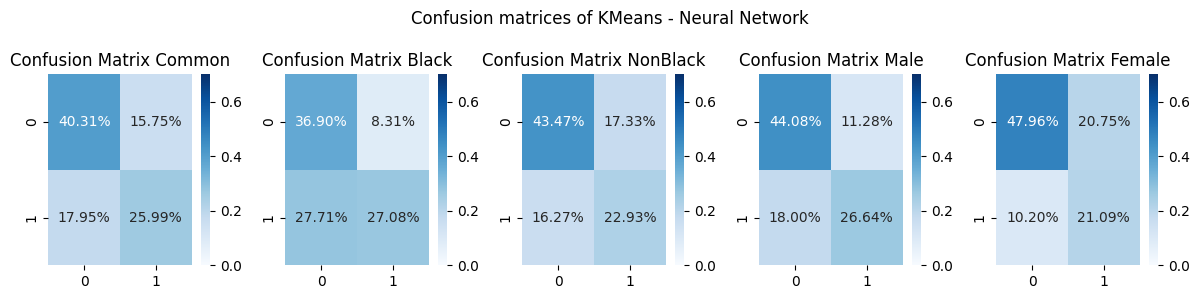

In [ ]:
predict = np.rint(np.array(gbc.predict_proba(features_test)[:, 1], 'f'))
predict_black = np.rint(np.array(gbc.predict_proba(features_test_black)[:, 1], 'f'))
predict_nonblack =  np.rint(np.array(gbc.predict_proba(features_test_nonblack)[:, 1], 'f'))
predict_male = np.rint(np.array(gbc.predict_proba(features_test_male)[:, 1], 'f'))
predict_female = np.rint(np.array(gbc.predict_proba(features_test_female)[:, 1], 'f'))

cm = confusion_matrix(labels_test, predict)
cm_black = confusion_matrix(labels_test_black, predict_black)
cm_nonblack = confusion_matrix(labels_test_nonblack, predict_nonblack)
cm_male = confusion_matrix( labels_test_male, predict_male)
cm_female = confusion_matrix(labels_test_female, predict_female)

fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(12, 3))
fig.suptitle('Confusion matrices of KMeans - Neural Network')

sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues', ax=ax1, vmin=0.0, vmax=0.7)
ax1.set_title("Confusion Matrix Common")
sns.heatmap(cm_black / np.sum(cm_black), annot=True, fmt='.2%', cmap='Blues', ax=ax2, vmin=0.0, vmax=0.7)
ax2.set_title("Confusion Matrix Black")
sns.heatmap(cm_nonblack / np.sum(cm_nonblack), annot=True, fmt='.2%', cmap='Blues', ax=ax3, vmin=0.0, vmax=0.7)
ax3.set_title("Confusion Matrix NonBlack")
sns.heatmap(cm_male / np.sum(cm_male), annot=True, fmt='.2%', cmap='Blues', ax=ax4, vmin=0.0, vmax=0.7)
ax4.set_title("Confusion Matrix Male")

sns.heatmap(cm_female / np.sum(cm_female), annot=True, fmt='.2%', cmap='Blues', ax=ax5, vmin=0.0, vmax=0.7)
ax5.set_title("Confusion Matrix Female")

for ax in fig.get_axes():
  ax.label_outer()

fig.tight_layout()
fig.show()

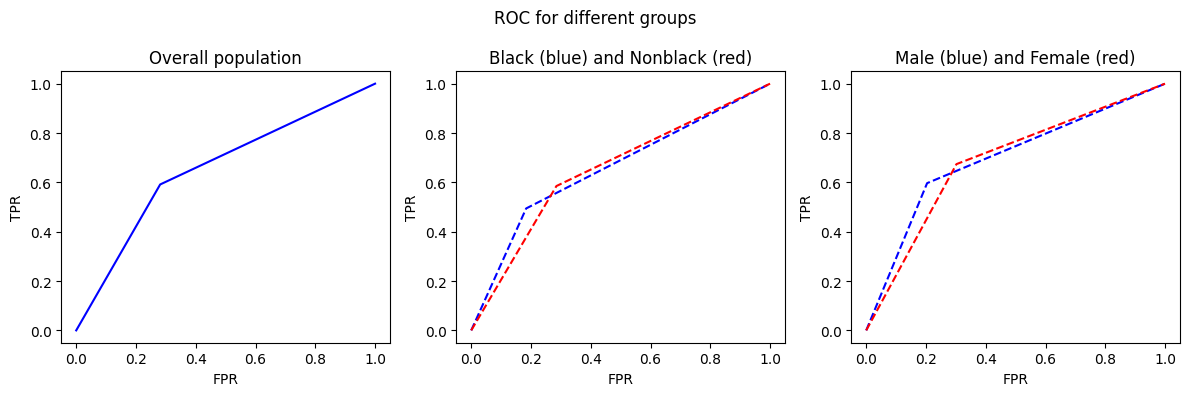

In [ ]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle('ROC for different groups')

scores = np.rint(np.array(gbc.predict_proba(features_test)[:, 1], 'f'))
fpr, tpr, thresholds = roc_curve(labels_test, scores)
ax1.plot(fpr, tpr, 'b')
ax1.set_title('Overall population')
ax1.set_xlabel("FPR")
ax1.set_ylabel("TPR")

scores_black = np.rint(np.array(gbc.predict_proba(features_test_black)[:, 1], 'f'))
fpr_black, tpr_black, thresholds_black = roc_curve(labels_test_black, scores_black)
scores_nonblack = np.rint(np.array(gbc.predict_proba(features_test_nonblack)[:, 1], 'f'))
fpr_nonblack, tpr_nonblack, thresholds_nonblack = roc_curve(labels_test_nonblack, scores_nonblack)
ax2.plot(fpr_black, tpr_black, 'b--', fpr_nonblack, tpr_nonblack, 'r--')
ax2.set_title('Black (blue) and Nonblack (red)')
ax2.set_xlabel("FPR")
ax2.set_ylabel("TPR")

scores_male = np.rint(np.array(gbc.predict_proba(features_test_male)[:, 1], 'f'))
fpr_male, tpr_male, thresholds_male = roc_curve(labels_test_male, scores_male)
scores_female = np.rint(np.array(gbc.predict_proba(features_test_female)[:, 1], 'f'))
fpr_female, tpr_female, thresholds_female = roc_curve(labels_test_female, scores_female)
ax3.plot(fpr_male, tpr_male, 'b--', fpr_female, tpr_female, 'r--')
ax3.set_title('Male (blue) and Female (red)')
ax3.set_xlabel("FPR")
ax3.set_ylabel("TPR")

fig.tight_layout()
fig.show()

#Conclusion

What did we look at in this Jupyter Notebook? 
First, we looked at the COMPASS dataset. We could show that it values different groups differently. So there is a BIAS regarding black people and non-black people as well as between women and men. The dataset treats black people and women more unfairly.

But what does fairness actually mean? We looked at various terms that one would want to have as desirable characteristics to achieve fairness. These are and were defined during the analysis:
- Demograpic Parity, 
- Accuracy Parity, 
- PVP Parity. 

As a tool, we looked at the following values.
- Customized score function (different thresholds for different groups)
- FPR/TPR (ROC Curve)
- Calibration
- Equalized Odds 

In the lecture we also learned that only a perfect classifier fulfills all these attributes and that otherwise the goals of improving a property are mutually exclusive.

We trained different classifiers with our dataset and analyzed the results using the same methods as for the COMPASS dataset.
- Linear Regression 
- Logistic Regression
- KNN
- Neural Network
- Stochastic Gradient Descent
- SVM
- Decision Trees
- Combination of KMeans and MLP
- Gradient Boosting Classifier

We used GridSearch to tune the respective hyperparameters. 
Then we looked at the Confusion Matrix, ROC Curves, Calibration plots, Accuracy for the whole dataset and for subgroups. We also rescaled the dataset and then looked at the values again. In addition, we tried to work out complex neural networks with Pytorch and Tensorflow, but we did not succeed.



Outlook: 
- Using Ensemble Techniques (Boosting Techniques)

